In [1]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================
# game-behavior-analytics/
# ├── data_analysis_notebook/
# │   └── analysis(PL+SM).ipynb
# ├── data/
# │   └── final_dataset.csv

# Change to the correct directory
%cd game-behavior-analytics/data_analysis_notebook/ 

/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


/opt/anaconda3/envs/cheating_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# ============================================================================
# PROJECT FOLDER STRUCTURE & DATA PREPARATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
df = pd.read_csv("../data/final_dataset.csv")

def categorize_cheating(rate):
    if rate == 0: return 0  # Non-cheater
    elif rate == 1: return 2  # Full cheater
    else: return 1  # Partial cheater

df['cheating_behavior'] = df['cheating_rate_main_round'].apply(categorize_cheating)
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2
df['performance'] = df['performance_score_including_cheated_words']
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept'])

# Prepare variables for analysis
concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

y_cheating = df['cheating_behavior'].values
y_performance = df['performance'].values
y_experience = df['experience'].values

# Control group baselines
control_data = df[df['concept'] == 'control']
control_cheating_counts = control_data['cheating_behavior'].value_counts().sort_index()
control_performance_mean = control_data['performance'].mean()
control_experience_mean = control_data['experience'].mean()

# Standardization
perf_std = np.std(y_performance)
exp_std = np.std(y_experience)

print(f"Dataset: {len(df)} participants")
print(f"Control: {len(control_data)}, Intervention: {len(df) - len(control_data)}")


# Calculate correlations by subgroup for model selection
corr_results = []
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for group_name, group_data in [('Control', control_data), ('Intervention', df[df['concept'] != 'control'])]:
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]
        if len(subset) >= 10:
            corr = subset[['performance', 'experience']].corr().iloc[0, 1]
        else:
            corr = None
        corr_results.append({
            'Group': group_name,
            'Cheating Category': cheating_labels[cheat_cat],
            'n': len(subset),
            'Correlation': round(corr, 3) if corr is not None else 'NA'
        })

# Display table
corr_table = pd.DataFrame(corr_results)
print("Correlation between performance and experience by group and cheating category:")
print(corr_table.to_string(index=False))

# Decision criterion
significant_corrs = sum(
    1 for row in corr_results
    if isinstance(row['Correlation'], float) and abs(row['Correlation']) > 0.1 and row['n'] >= 10
)
use_multivariate = significant_corrs >= 3

print(f"\nDecision: {significant_corrs}/6 groups have |r|>0.1")
print(f"Using {'multivariate' if use_multivariate else 'separate'} model(s) for performance and experience later")

Dataset: 1232 participants
Control: 73, Intervention: 1159
Correlation between performance and experience by group and cheating category:
       Group Cheating Category   n  Correlation
     Control      Non-cheaters  39        0.339
     Control  Partial cheaters  10       -0.427
     Control     Full cheaters  24        0.203
Intervention      Non-cheaters 734        0.115
Intervention  Partial cheaters 203        0.006
Intervention     Full cheaters 222        0.222

Decision: 5/6 groups have |r|>0.1
Using multivariate model(s) for performance and experience later



5.6.1. EFFECT OF CONCEPT-BASED INTERVENTIONS ON CHEATING BEHAVIOR

5.6.1.1. Descriptive Statistics of Cheating Behavior
------------------------------------------------------------


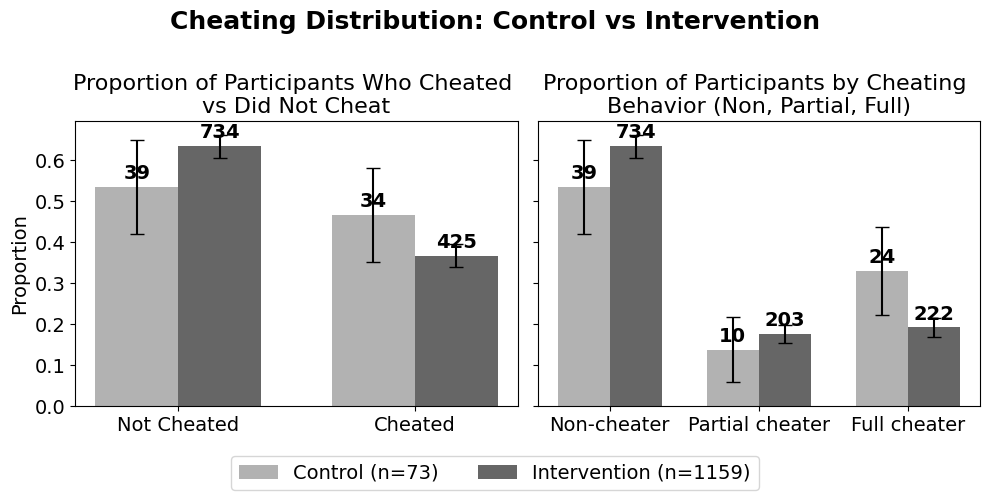


===== PROPORTION OF CHEATERS =====
Control group:
- Total N = 73
- Cheated: 34 participants (46.6%, 95% CI [35.1%, 58.0%])

Intervention group:
- Total N = 1159
- Cheated: 425 participants (36.7%, 95% CI [33.9%, 39.4%])

===== CHEATING BEHAVIOR BREAKDOWN =====

Control group:
Non-cheater: 39 participants (53.4%, 95% CI [42.0%, 64.9%])
Partial cheater: 10 participants (13.7%, 95% CI [5.8%, 21.6%])
Full cheater: 24 participants (32.9%, 95% CI [22.1%, 43.7%])

Intervention group:
Non-cheater: 734 participants (63.3%, 95% CI [60.6%, 66.1%])
Partial cheater: 203 participants (17.5%, 95% CI [15.3%, 19.7%])
Full cheater: 222 participants (19.2%, 95% CI [16.9%, 21.4%])


In [3]:
# ============================================================================
# 5.6.1. EFFECT OF CONCEPT-BASED INTERVENTIONS ON CHEATING BEHAVIOR
# ============================================================================

print("\n" + "="*80)
print("5.6.1. EFFECT OF CONCEPT-BASED INTERVENTIONS ON CHEATING BEHAVIOR")
print("="*80)

# ============================================================================
# 5.6.1.1. Descriptive Statistics of Cheating Behavior
# ============================================================================

print("\n5.6.1.1. Descriptive Statistics of Cheating Behavior")
print("-" * 60)

# Calculate descriptive statistics
cheating_labels = {0: 'Non-cheater', 1: 'Partial cheater', 2: 'Full cheater'}
control_rates = control_data['cheating_behavior'].value_counts(normalize=True).sort_index() * 100
intervention_rates = df[df['concept'] != 'control']['cheating_behavior'].value_counts(normalize=True).sort_index() * 100

df['cheated_binary'] = (df['cheating_behavior'] > 0).astype(int)

# Helper function
def prop_ci(data, col, categories):
    n = len(data)
    props, ci_l, ci_u, counts = [], [], [], []
    for cat in categories:
        count = (data[col] == cat).sum()
        prop = count / n
        se = np.sqrt(prop * (1 - prop) / n)
        ci_low = max(0, prop - 1.96 * se)
        ci_high = min(1, prop + 1.96 * se)
        props.append(prop)
        ci_l.append(ci_low)
        ci_u.append(ci_high)
        counts.append(count)
    return props, ci_l, ci_u, counts

# Data subsets
control = df[df['concept'] == 'control']
intervention = df[df['concept'] != 'control']

# Figure setup
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Common settings
bar_width = 0.35
font_large = 14

# -------------------------
# PLOT 1: Cheated or Not
# -------------------------
cats1 = [0, 1]
control_p1, ci_l1, ci_u1, counts1 = prop_ci(control, 'cheated_binary', cats1)
interv_p1, ci_l2, ci_u2, counts2 = prop_ci(intervention, 'cheated_binary', cats1)

x = np.arange(len(cats1))
ax = axes[0]

bars1 = ax.bar(x - bar_width/2, control_p1, bar_width, 
               yerr=[np.array(control_p1)-np.array(ci_l1), np.array(ci_u1)-np.array(control_p1)],
               capsize=5, label=f'Control (n={len(control)})', color='gray', alpha=0.6)

bars2 = ax.bar(x + bar_width/2, interv_p1, bar_width,
               yerr=[np.array(interv_p1)-np.array(ci_l2), np.array(ci_u2)-np.array(interv_p1)],
               capsize=5, label=f'Intervention (n={len(intervention)})', color='black', alpha=0.6)

# Annotate counts
for bars, counts in zip([bars1, bars2], [counts1, counts2]):
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                count, ha='center', va='bottom', fontweight='bold', fontsize=font_large)

ax.set_xticks(x)
ax.set_xticklabels(['Not Cheated', 'Cheated'], fontsize=font_large)
ax.set_title('Proportion of Participants Who Cheated \nvs Did Not Cheat', fontsize=font_large + 2)
ax.set_ylabel('Proportion', fontsize=font_large)
ax.tick_params(axis='y', labelsize=font_large)

# -------------------------
# PLOT 2: Cheating Groups
# -------------------------
cats2 = [0, 1, 2]
control_p2, ci_l3, ci_u3, counts3 = prop_ci(control, 'cheating_behavior', cats2)
interv_p2, ci_l4, ci_u4, counts4 = prop_ci(intervention, 'cheating_behavior', cats2)

x2 = np.arange(len(cats2))
ax = axes[1]

bars3 = ax.bar(x2 - bar_width/2, control_p2, bar_width, 
               yerr=[np.array(control_p2)-np.array(ci_l3), np.array(ci_u3)-np.array(control_p2)],
               capsize=5, label=f'Control (n={len(control)})', color='gray', alpha=0.6)

bars4 = ax.bar(x2 + bar_width/2, interv_p2, bar_width,
               yerr=[np.array(interv_p2)-np.array(ci_l4), np.array(ci_u4)-np.array(interv_p2)],
               capsize=5, label=f'Intervention (n={len(intervention)})', color='black', alpha=0.6)

# Annotate counts
for bars, counts in zip([bars3, bars4], [counts3, counts4]):
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                count, ha='center', va='bottom', fontweight='bold', fontsize=font_large)

ax.set_xticks(x2)
ax.set_xticklabels(['Non-cheater', 'Partial cheater', 'Full cheater'], fontsize=font_large)
ax.set_title('Proportion of Participants by Cheating \nBehavior (Non, Partial, Full)', fontsize=font_large + 2)
ax.tick_params(axis='y', labelsize=font_large)


# Get handles and labels from the last axis
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=font_large)

plt.suptitle('Cheating Distribution: Control vs Intervention', fontsize=font_large + 4, fontweight='bold')
plt.tight_layout(rect=[0, 0.1, 1, 0.96])
plt.show()

print("\n===== PROPORTION OF CHEATERS =====")

print(f"Control group:")
print(f"- Total N = {len(control)}")
print(f"- Cheated: {counts1[1]} participants ({control_p1[1]*100:.1f}%, 95% CI [{ci_l1[1]*100:.1f}%, {ci_u1[1]*100:.1f}%])")

print(f"\nIntervention group:")
print(f"- Total N = {len(intervention)}")
print(f"- Cheated: {counts2[1]} participants ({interv_p1[1]*100:.1f}%, 95% CI [{ci_l2[1]*100:.1f}%, {ci_u2[1]*100:.1f}%])")

print("\n===== CHEATING BEHAVIOR BREAKDOWN =====")

print("\nControl group:")
for i, cat in enumerate(['Non-cheater', 'Partial cheater', 'Full cheater']):
    print(f"{cat}: {counts3[i]} participants ({control_p2[i]*100:.1f}%, 95% CI [{ci_l3[i]*100:.1f}%, {ci_u3[i]*100:.1f}%])")

print("\nIntervention group:")
for i, cat in enumerate(['Non-cheater', 'Partial cheater', 'Full cheater']):
    print(f"{cat}: {counts4[i]} participants ({interv_p2[i]*100:.1f}%, 95% CI [{ci_l4[i]*100:.1f}%, {ci_u4[i]*100:.1f}%])")



In [4]:
# ============================================================================
# 5.6.1.2. Statistical Analyses of Effect of Interventions on Cheating Behavior
# ============================================================================

print("\n5.6.1.2. Statistical Analyses of Effect of Interventions on Cheating Behavior")
print("-" * 70)

# Bayesian Multinomial Logistic Regression
with pm.Model() as cheating_model:
    # Control group baseline (empirical priors)
    n_total = control_cheating_counts.sum()
    n_non, n_partial, n_full = control_cheating_counts[0], control_cheating_counts[1], control_cheating_counts[2]
    
    control_partial_logit = np.log(n_partial / n_non) if n_non > 0 else -2
    control_full_logit = np.log(n_full / n_non) if n_non > 0 else -1
    se_partial = np.sqrt(1/n_partial + 1/n_non) if n_partial > 0 and n_non > 0 else 1.0
    se_full = np.sqrt(1/n_full + 1/n_non) if n_full > 0 and n_non > 0 else 1.0
    
    beta_partial_intercept = pm.Normal('beta_partial_intercept', mu=control_partial_logit, sigma=se_partial)
    beta_full_intercept = pm.Normal('beta_full_intercept', mu=control_full_logit, sigma=se_full)
    
    # Concept effects
    concept_effects_partial = pm.Normal('concept_effects_partial', mu=-0.5, sigma=1.0, shape=len(concepts))
    concept_effects_full = pm.Normal('concept_effects_full', mu=-0.5, sigma=1.0, shape=len(concepts))
    
    # Message random effects
    message_effects_partial = pm.Normal('message_effects_partial', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    message_effects_full = pm.Normal('message_effects_full', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    
    # Linear predictors
    eta_partial = (beta_partial_intercept + message_effects_partial[message_codes] + 
                   pm.math.switch(concept_codes > 0, concept_effects_partial[concept_codes - 1], 0))
    eta_full = (beta_full_intercept + message_effects_full[message_codes] + 
                pm.math.switch(concept_codes > 0, concept_effects_full[concept_codes - 1], 0))
    
    # Multinomial logistic probabilities
    logits = pm.math.stack([pm.math.zeros(eta_partial.shape), eta_partial, eta_full], axis=1)
    probs = pm.math.softmax(logits, axis=1)
    
    pm.Categorical('cheating_obs', p=probs, observed=y_cheating)

# Fit model
with cheating_model:
    trace_cheating = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)



5.6.1.2. Statistical Analyses of Effect of Interventions on Cheating Behavior
----------------------------------------------------------------------


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, concept_effects_partial, concept_effects_full, message_effects_partial, message_effects_full]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.


In [5]:
# =============================
# SUMMARY OF RESULTS (Posteriors)
# =============================

# Calculate predicted probabilities with HDI
beta_partial_samples = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
beta_full_samples = trace_cheating.posterior['beta_full_intercept'].values.flatten()
partial_effects = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
full_effects = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))

# Control group probabilities
control_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples,
    beta_full_samples
])
control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

# Order concepts by theory
theory_order = [
    'autonomy', 'competence', 'relatedness',  # Self-Determination
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # Cognitive Dissonance
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # Self-Efficacy
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # Social Norms
]
theory_map = {
    'autonomy': 'Self-Determination Theory', 'competence': 'Self-Determination Theory', 'relatedness': 'Self-Determination Theory',
    'self_concept': 'Cognitive Dissonance Theory', 'cognitive_inconsistency': 'Cognitive Dissonance Theory', 
    'dissonance_arousal': 'Cognitive Dissonance Theory', 'dissonance_reduction': 'Cognitive Dissonance Theory',
    'performance_accomplishments': 'Self-Efficacy Theory', 'vicarious_experience': 'Self-Efficacy Theory', 
    'verbal_persuasion': 'Self-Efficacy Theory', 'emotional_arousal': 'Self-Efficacy Theory',
    'descriptive_norms': 'Social Norms Theory', 'injunctive_norms': 'Social Norms Theory', 
    'social_sanctions': 'Social Norms Theory', 'reference_group_identification': 'Social Norms Theory'
}

# Calculate differences for each concept with HDI
results_cheating = []
concept_differences = {}  # Store for reuse in forest plots

for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        concept_logits = np.column_stack([
            np.zeros(len(beta_partial_samples)),
            beta_partial_samples + partial_effects[:, i],
            beta_full_samples + full_effects[:, i]
        ])
        concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)
        
        # Differences with HDI
        non_diff = (concept_probs[:, 0] - control_probs[:, 0]) * 100
        partial_diff = (concept_probs[:, 1] - control_probs[:, 1]) * 100
        full_diff = (concept_probs[:, 2] - control_probs[:, 2]) * 100
        
        # Store for reuse
        concept_differences[concept] = {
            'non_diff': non_diff,
            'partial_diff': partial_diff,
            'full_diff': full_diff
        }
        
        results_cheating.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': non_diff.mean(),
            'Non_hdi': az.hdi(non_diff, hdi_prob=0.95),
            'Partial_mean': partial_diff.mean(),
            'Partial_hdi': az.hdi(partial_diff, hdi_prob=0.95),
            'Full_mean': full_diff.mean(),
            'Full_hdi': az.hdi(full_diff, hdi_prob=0.95)
        })

df_results = pd.DataFrame(results_cheating)

# Control baseline for labels
control_rates = {
    'Non': control_probs[:, 0].mean() * 100,
    'Partial': control_probs[:, 1].mean() * 100,
    'Full': control_probs[:, 2].mean() * 100
}

# Calculate overall intervention effects for reuse
overall_partial_effects = partial_effects.mean(axis=1)  
overall_full_effects = full_effects.mean(axis=1)

overall_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples + overall_partial_effects,
    beta_full_samples + overall_full_effects
])
overall_probs = np.exp(overall_logits) / np.exp(overall_logits).sum(axis=1, keepdims=True)

overall_results = {}
for i, category in enumerate(['Non', 'Partial', 'Full']):
    diff = (overall_probs[:, i] - control_probs[:, i]) * 100
    overall_results[category] = {
        'mean': diff.mean(),
        'hdi': az.hdi(diff, hdi_prob=0.95)
    }

# Print with HDI
print("Cheating Behavior Changes (percentage points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results.iterrows():
    non_str = f"{row['Non_mean']:+.1f} [{row['Non_hdi'][0]:+.1f}, {row['Non_hdi'][1]:+.1f}]"
    partial_str = f"{row['Partial_mean']:+.1f} [{row['Partial_hdi'][0]:+.1f}, {row['Partial_hdi'][1]:+.1f}]"
    full_str = f"{row['Full_mean']:+.1f} [{row['Full_hdi'][0]:+.1f}, {row['Full_hdi'][1]:+.1f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")


Cheating Behavior Changes (percentage points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +13.5 [-1.2, +27.2]       +0.4 [-12.1, +13.1]       -13.9 [-26.6, -1.5]      
Competence                          Self-Determination Theory      +13.3 [-0.9, +26.7]       -4.9 [-14.7, +5.6]        -8.4 [-20.6, +6.3]       
Relatedness                         Self-Determination Theory      +11.7 [-2.6, +25.3]       -5.3 [-14.9, +5.8]        -6.3 [-19.9, +8.3]       
Self Concept                        Cognitive Dissonance Theory    +11.5 [-2.0, +25.9]       -1.2 [-12.4, +10.5]       -10.3 [-22.9, +3.6]      
Cognitive Inconsistency             Cognitive Dissonance Theory    +14.3 [+0.3, +27.

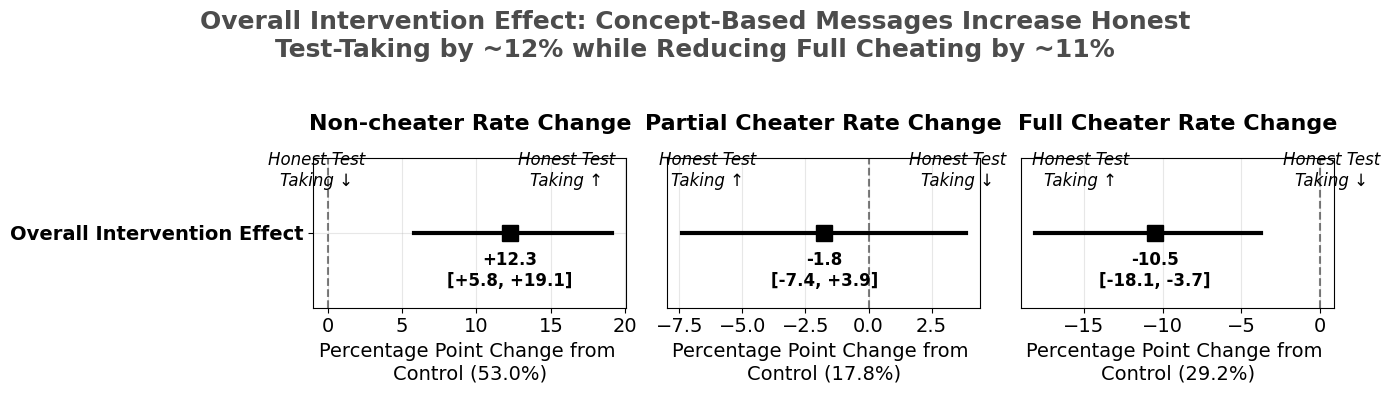

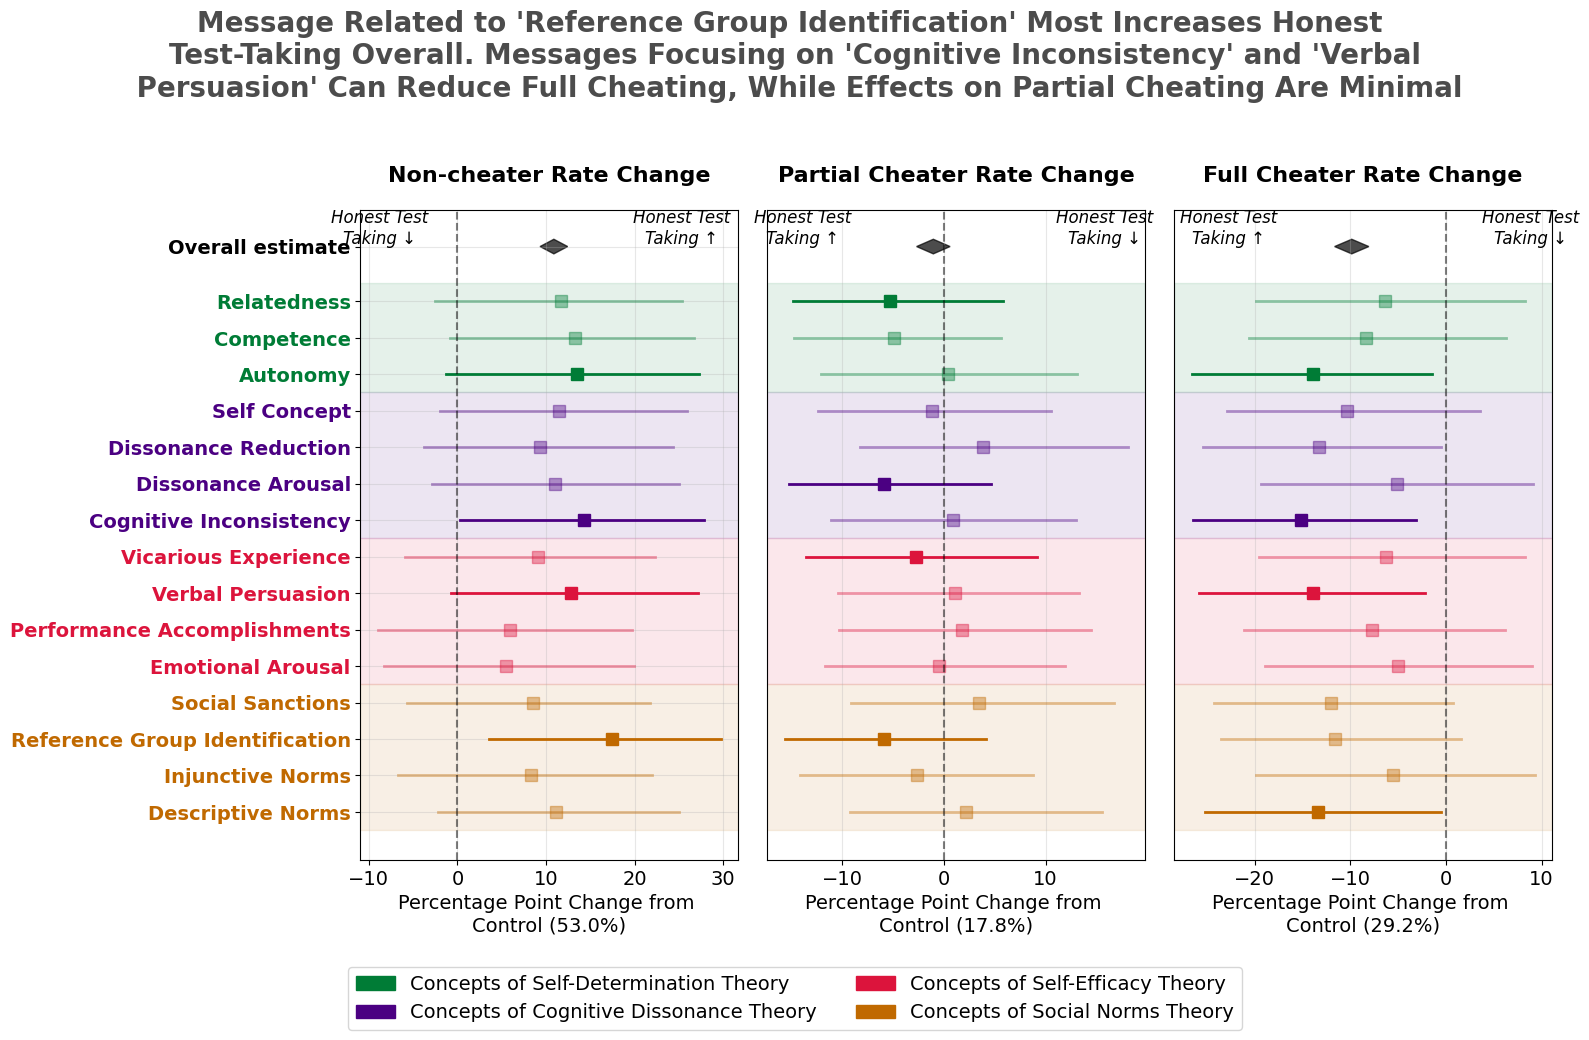

In [6]:
# ===============================================================
# FOREST PLOTS FOR CHEATING BEHAVIOR (posterior with 95% HDI)

# RQ1a.  Do concept-based interventions reduce cheating behavior?
# RQ1b.  Do the effects on cheating vary by concepts?
# ================================================================

def create_forest_plots():
    """Create forest plots reusing calculated values from summary"""
    
    categories = ['Non', 'Partial', 'Full']
    titles = ['Non-cheater Rate Change', 'Partial Cheater Rate Change', 'Full Cheater Rate Change']
    
    # PLOT 1: Overall intervention effect (reuse overall_results)
    fig1, axes1 = plt.subplots(1, 3, figsize=(14, 4))
    
    for idx, (cat, title) in enumerate(zip(categories, titles)):
        ax = axes1[idx]
        
        mean = overall_results[cat]['mean']
        hdi = overall_results[cat]['hdi']
        
        ax.plot([hdi[0], hdi[1]], [0, 0], color='black', linewidth=3)
        ax.plot(mean, 0, 's', color='black', markersize=12)
        
        ax.text(mean, -0.15, f'{mean:+.1f}\n[{hdi[0]:+.1f}, {hdi[1]:+.1f}]', 
                ha='center', va='center', fontweight='bold', fontsize=12)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        
        if idx == 0:
            ax.set_yticks([0])
            ax.set_yticklabels(['Overall Intervention Effect'], fontsize=14, fontweight='bold')
        else:
            ax.set_yticks([])
        
        ax.tick_params(axis='x', labelsize=14)
        ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
        ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.3, 0.3)
        
        xlim = ax.get_xlim()
        if cat == 'Non':
            ax.text(xlim[0] * 0.8, 0.25, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, 0.25, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
        else:
            ax.text(xlim[0] * 0.8, 0.25, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, 0.25, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')

    plt.suptitle('Overall Intervention Effect: Concept-Based Messages Increase Honest\nTest-Taking by ~12% while Reducing Full Cheating by ~11%', 
                 fontsize=18, fontweight='bold', color="black", alpha=0.7, y=0.97)
    plt.tight_layout()
    plt.subplots_adjust(top=0.6)
    plt.show()
    
    # PLOT 2: By-concept effects (reuse df_results)
    import matplotlib.patches as patches
    
    fig2, axes2 = plt.subplots(1, 3, figsize=(16, 10))
    
    theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 'Self-Efficacy Theory', 'Social Norms Theory'][::-1]
    theory_colors = {'Self-Determination Theory': "#007C36", 'Cognitive Dissonance Theory': '#4B0082',
                     'Self-Efficacy Theory': '#DC143C', 'Social Norms Theory': "#C06900"}
    
    df_results['Theory'] = pd.Categorical(df_results['Theory'], categories=theory_order_viz, ordered=True)
    df_results_sorted = df_results.sort_values(['Theory', 'Concept']).reset_index(drop=True)
    
    for idx, (cat, title) in enumerate(zip(categories, titles)):
        ax = axes2[idx]
        means = df_results_sorted[f'{cat}_mean'].values
        hdis = np.array([row[f'{cat}_hdi'] for _, row in df_results_sorted.iterrows()])
        
        y_positions = np.arange(len(df_results_sorted))
        
        # Highlight best concept per theory
        highlight_indices = []
        for theory in theory_order_viz:
            indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
            if indices:
                theory_means = means[indices]
                target_idx = indices[np.argmax(theory_means)] if cat == 'Non' else indices[np.argmin(theory_means)]
                highlight_indices.append(target_idx)
        
        # Background shading and forest plot
        for theory in theory_order_viz:
            indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
            if indices:
                ax.axhspan(indices[0]-0.5, indices[-1]+0.5, alpha=0.1, color=theory_colors[theory])
        
        for i in range(len(df_results_sorted)):
            color = theory_colors[df_results_sorted.iloc[i]['Theory']]
            alpha = 1.0 if i in highlight_indices else 0.4
            ax.plot([hdis[i][0], hdis[i][1]], [i, i], color=color, alpha=alpha, linewidth=2)
            ax.plot(means[i], i, 's', color=color, alpha=alpha, markersize=8)
        
        # Overall estimate diamond
        overall_mean = means.mean()
        overall_se = np.std(means) / np.sqrt(len(means))
        diamond_y = len(df_results_sorted) + 0.5
        diamond_x = [overall_mean - 1.96*overall_se, overall_mean, overall_mean + 1.96*overall_se, overall_mean, overall_mean - 1.96*overall_se]
        diamond_y_coords = [diamond_y, diamond_y + 0.2, diamond_y, diamond_y - 0.2, diamond_y]
        ax.fill(diamond_x, diamond_y_coords, color='black', alpha=0.7)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)

        if idx == 0:
            ax.set_yticks(list(y_positions) + [diamond_y])
            y_labels = df_results_sorted['Concept'].tolist() + ['Overall estimate']
            ax.set_yticklabels(y_labels, fontsize=14, fontweight='bold')

            for tick_label, concept in zip(ax.get_yticklabels()[:-1], df_results_sorted['Concept']):
                theory = df_results_sorted.loc[df_results_sorted['Concept'] == concept, 'Theory'].values[0]
                tick_label.set_color(theory_colors[theory])
            ax.get_yticklabels()[-1].set_color('black')
        else:
            ax.set_yticks([])

        ax.tick_params(axis='x', labelsize=14)
        ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
        ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
        
        xlim = ax.get_xlim()
        if cat == 'Non':
            ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
        else:
            ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')

    legend_elements = [patches.Patch(color=color, label=f"Concepts of {theory}") for theory, color in theory_colors.items()]
    fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=14)

    plt.suptitle('Message Related to \'Reference Group Identification\' Most Increases Honest \nTest-Taking Overall. Messages Focusing on \'Cognitive Inconsistency\' and \'Verbal\n Persuasion\' Can Reduce Full Cheating, While Effects on Partial Cheating Are Minimal', 
             fontsize=20, fontweight='bold', color='black', alpha=0.7, y=0.95)

    plt.tight_layout()
    plt.subplots_adjust(top=0.75, bottom=0.1)
    plt.show()

# Execute the function
create_forest_plots()


5.6.2. EFFECT OF CONCEPT-BASED INTERVENTIONS ON PERFORMANCE AND USER EXPERIENCE

5.6.2.1. Descriptive Statistics of Performance
------------------------------------------------------------
Control group performance:
  N = 73
  Mean = 20.60 (SD = 12.73)
  95% CI = [17.68, 23.52]
Intervention group performance:
  N = 1159
  Mean = 19.34 (SD = 11.64)
  95% CI = [18.67, 20.01]

Performance by cheating behavior:

Control group:
  Non-cheater: 14.67 (SD=7.91, n=39)
  Partial cheater: 20.60 (SD=11.85, n=10)
  Full cheater: 30.25 (SD=13.85, n=24)

Intervention group:
  Non-cheater: 17.19 (SD=10.37, n=734)
  Partial cheater: 17.94 (SD=9.18, n=203)
  Full cheater: 27.73 (SD=13.73, n=222)

5.6.2.2. Descriptive Statistics of User Experience
------------------------------------------------------------
Control group experience:
  N = 73
  Mean = 5.55 (SD = 0.93)
  95% CI = [5.34, 5.76]
Intervention group experience:
  N = 1159
  Mean = 5.60 (SD = 0.80)
  95% CI = [5.56, 5.65]

Experience by cheatin

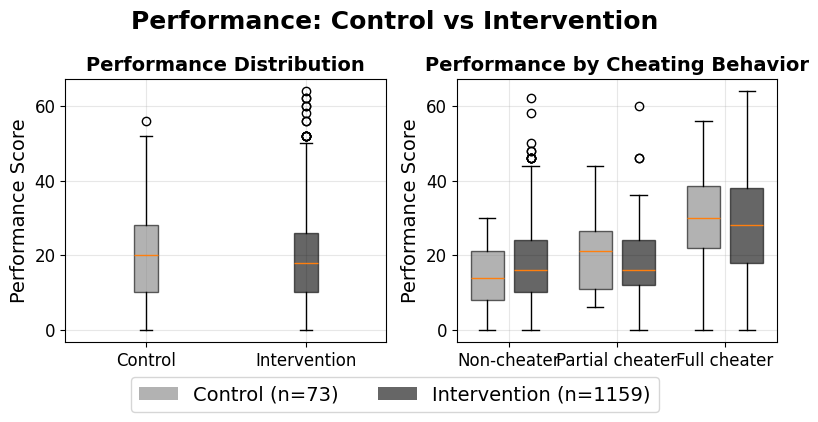

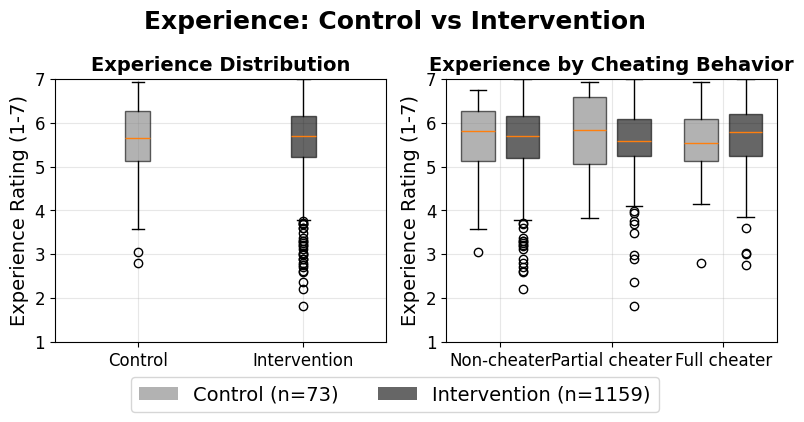

In [7]:
# ============================================================================
# 5.6.2. EFFECT OF CONCEPT-BASED INTERVENTIONS ON PERFORMANCE AND USER EXPERIENCE
# ============================================================================

print("\n" + "="*80)
print("5.6.2. EFFECT OF CONCEPT-BASED INTERVENTIONS ON PERFORMANCE AND USER EXPERIENCE")
print("="*80)

# ============================================================================
# 5.6.2.1. Descriptive Statistics of Performance
# ============================================================================

print("\n5.6.2.1. Descriptive Statistics of Performance")
print("-" * 60)

# Performance statistics by group
control_perf = control_data['performance']
intervention_perf = df[df['concept'] != 'control']['performance']

# Calculate means and CIs for performance
def calculate_stats(data, name):
    mean_val = data.mean()
    std_val = data.std()
    n = len(data)
    se = std_val / np.sqrt(n)
    ci_low = mean_val - 1.96 * se
    ci_high = mean_val + 1.96 * se
    
    print(f"{name}:")
    print(f"  N = {n}")
    print(f"  Mean = {mean_val:.2f} (SD = {std_val:.2f})")
    print(f"  95% CI = [{ci_low:.2f}, {ci_high:.2f}]")
    return mean_val, ci_low, ci_high, n

control_perf_stats = calculate_stats(control_perf, "Control group performance")
intervention_perf_stats = calculate_stats(intervention_perf, "Intervention group performance")

# Performance by cheating behavior
print("\nPerformance by cheating behavior:")
cheating_labels = {0: 'Non-cheater', 1: 'Partial cheater', 2: 'Full cheater'}

for group_name, group_data in [('Control', control_data), ('Intervention', df[df['concept'] != 'control'])]:
    print(f"\n{group_name} group:")
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]['performance']
        if len(subset) > 0:
            print(f"  {cheating_labels[cheat_cat]}: {subset.mean():.2f} (SD={subset.std():.2f}, n={len(subset)})")

# ============================================================================
# 5.6.2.2. Descriptive Statistics of User Experience
# ============================================================================

print("\n5.6.2.2. Descriptive Statistics of User Experience")
print("-" * 60)

# Experience statistics by group
control_exp = control_data['experience']
intervention_exp = df[df['concept'] != 'control']['experience']

control_exp_stats = calculate_stats(control_exp, "Control group experience")
intervention_exp_stats = calculate_stats(intervention_exp, "Intervention group experience")

# Experience by cheating behavior
print("\nExperience by cheating behavior:")

for group_name, group_data in [('Control', control_data), ('Intervention', df[df['concept'] != 'control'])]:
    print(f"\n{group_name} group:")
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]['experience']
        if len(subset) > 0:
            print(f"  {cheating_labels[cheat_cat]}: {subset.mean():.2f} (SD={subset.std():.2f}, n={len(subset)})")

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

positions = [0, 1, 2]

# ============================================================================
# VISUALIZATION: Performance Distributions
# ============================================================================

fig1, axes1 = plt.subplots(1, 2, figsize=(8, 4))

# Performance overall boxplot
axes1[0].boxplot([control_perf, intervention_perf], labels=['Control', 'Intervention'], patch_artist=True)
for i, patch in enumerate(axes1[0].patches):
    patch.set_facecolor(['gray', 'black'][i])
    patch.set_alpha(0.6)
axes1[0].set_title('Performance Distribution', fontweight='bold', fontsize=14)
axes1[0].set_ylabel('Performance Score', fontsize=14)
axes1[0].tick_params(axis='x', labelsize=12)
axes1[0].tick_params(axis='y', labelsize=12)
axes1[0].grid(True, alpha=0.3)

# Performance by cheating behavior
control_perf_by_cheat = [control_data[control_data['cheating_behavior'] == i]['performance'].values for i in range(3)]
intervention_perf_by_cheat = [df[(df['concept'] != 'control') & (df['cheating_behavior'] == i)]['performance'].values for i in range(3)]

bp1 = axes1[1].boxplot(control_perf_by_cheat, positions=[p - 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)
bp2 = axes1[1].boxplot(intervention_perf_by_cheat, positions=[p + 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)

for patch in bp1['boxes']:
    patch.set_facecolor('gray')
    patch.set_alpha(0.6)
for patch in bp2['boxes']:
    patch.set_facecolor('black')
    patch.set_alpha(0.6)

axes1[1].set_xticks(positions)
axes1[1].set_xticklabels(['Non-cheater', 'Partial cheater', 'Full cheater'], fontsize=12)
axes1[1].set_title('Performance by Cheating Behavior', fontweight='bold', fontsize=14)
axes1[1].set_ylabel('Performance Score', fontsize=14)
axes1[1].tick_params(axis='y', labelsize=12)
axes1[1].grid(True, alpha=0.3)

# Legend
legend_elements = [Patch(facecolor='gray', alpha=0.6, label=f'Control (n={len(control)})'),
                   Patch(facecolor='black', alpha=0.6, label=f'Intervention (n={len(intervention)})')]
fig1.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=14)

fig1.suptitle('Performance: Control vs Intervention', fontsize=18, fontweight='bold')
fig1.tight_layout()
fig1.subplots_adjust(bottom=0.15)
plt.show()


# ============================================================================
# VISUALIZATION: Experience Distributions
# ============================================================================

fig2, axes2 = plt.subplots(1, 2, figsize=(8, 4))

# Experience overall boxplot
axes2[0].boxplot([control_exp, intervention_exp], labels=['Control', 'Intervention'], patch_artist=True)
for i, patch in enumerate(axes2[0].patches):
    patch.set_facecolor(['gray', 'black'][i])
    patch.set_alpha(0.6)
axes2[0].set_title('Experience Distribution', fontweight='bold', fontsize=14)
axes2[0].set_ylabel('Experience Rating (1-7)', fontsize=14)
axes2[0].set_ylim(1, 7)
axes2[0].tick_params(axis='x', labelsize=12)
axes2[0].tick_params(axis='y', labelsize=12)
axes2[0].grid(True, alpha=0.3)

# Experience by cheating behavior
control_exp_by_cheat = [control_data[control_data['cheating_behavior'] == i]['experience'].values for i in range(3)]
intervention_exp_by_cheat = [df[(df['concept'] != 'control') & (df['cheating_behavior'] == i)]['experience'].values for i in range(3)]

bp1 = axes2[1].boxplot(control_exp_by_cheat, positions=[p - 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)
bp2 = axes2[1].boxplot(intervention_exp_by_cheat, positions=[p + 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)

for patch in bp1['boxes']:
    patch.set_facecolor('gray')
    patch.set_alpha(0.6)
for patch in bp2['boxes']:
    patch.set_facecolor('black')
    patch.set_alpha(0.6)

axes2[1].set_xticks(positions)
axes2[1].set_xticklabels(['Non-cheater', 'Partial cheater', 'Full cheater'], fontsize=12)
axes2[1].set_title('Experience by Cheating Behavior', fontweight='bold', fontsize=14)
axes2[1].set_ylabel('Experience Rating (1-7)', fontsize=14)
axes2[1].set_ylim(1, 7)
axes2[1].tick_params(axis='y', labelsize=12)
axes2[1].grid(True, alpha=0.3)

# Legend
fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=14)

fig2.suptitle('Experience: Control vs Intervention', fontsize=18, fontweight='bold')
fig2.tight_layout()
fig2.subplots_adjust(bottom=0.15)
plt.show()


In [8]:
# ============================================================================
# 5.6.2.3. Statistical Analyses of Effect on Performance and User Experience
# ============================================================================

print("\n5.6.2.3. Statistical Analyses of Effect on Performance and User Experience")
print("-" * 70)

# Control group baselines by cheating category
control_means_perf = []
control_means_exp = []

for cheat_cat in [0, 1, 2]:
    control_subset = control_data[control_data['cheating_behavior'] == cheat_cat]
    if len(control_subset) > 0:
        control_means_perf.append(control_subset['performance'].mean())
        control_means_exp.append(control_subset['experience'].mean())
    else:
        control_means_perf.append(control_performance_mean)
        control_means_exp.append(control_experience_mean)

print("Control group baselines by cheating category:")
print(f"Performance: {[f'{x:.2f}' for x in control_means_perf]}")
print(f"Experience: {[f'{x:.2f}' for x in control_means_exp]}")

# Multivariate Bayesian Model (since correlation > 0.1)
with pm.Model() as multivariate_model:
    # Control baselines by cheating category
    mu_exp_control = pm.Normal('mu_exp_control', mu=control_means_exp, sigma=0.3, shape=3)
    mu_perf_control = pm.Normal('mu_perf_control', mu=control_means_perf, sigma=3.0, shape=3)
    
    # Concept effects (main effects)
    concept_exp_main = pm.Normal('concept_exp_main', mu=0, sigma=0.2, shape=len(concepts))
    concept_perf_main = pm.Normal('concept_perf_main', mu=0, sigma=2.0, shape=len(concepts))
    
    # Concept × cheating category interactions
    concept_exp_interactions = pm.Normal('concept_exp_interactions', mu=0, sigma=0.15, shape=(len(concepts), 3))
    concept_perf_interactions = pm.Normal('concept_perf_interactions', mu=0, sigma=1.5, shape=(len(concepts), 3))
    
    # Message effects
    msg_exp = pm.Normal('msg_exp', mu=0, sigma=0.1, shape=len(message_ids.cat.categories))
    msg_perf = pm.Normal('msg_perf', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    
    # Linear predictors
    mu_exp = (mu_exp_control[y_cheating] + msg_exp[message_codes] + 
              pm.math.switch(concept_codes > 0,
                            concept_exp_main[concept_codes - 1] + concept_exp_interactions[concept_codes - 1, y_cheating], 0))

    mu_perf = (mu_perf_control[y_cheating] + msg_perf[message_codes] + 
               pm.math.switch(concept_codes > 0,
                             concept_perf_main[concept_codes - 1] + concept_perf_interactions[concept_codes - 1, y_cheating], 0))
    
    # Covariance structure
    sigma_exp = pm.HalfNormal('sigma_exp', sigma=0.4)
    sigma_perf = pm.HalfNormal('sigma_perf', sigma=5.0)
    rho = pm.Uniform('rho', lower=-0.5, upper=0.5)
    
    cov = pm.math.stack([[sigma_exp**2, rho*sigma_exp*sigma_perf],
                        [rho*sigma_exp*sigma_perf, sigma_perf**2]])
    
    # Multivariate likelihood
    outcomes = pm.math.stack([y_experience, y_performance], axis=1)
    means = pm.math.stack([mu_exp, mu_perf], axis=1)
    pm.MvNormal('outcomes', mu=means, cov=cov, observed=outcomes)

print("Fitting multivariate model...")
with multivariate_model:
    trace_multivariate = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)



5.6.2.3. Statistical Analyses of Effect on Performance and User Experience
----------------------------------------------------------------------
Control group baselines by cheating category:
Performance: ['14.67', '20.60', '30.25']
Experience: ['5.52', '5.69', '5.55']
Fitting multivariate model...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp_control, mu_perf_control, concept_exp_main, concept_perf_main, concept_exp_interactions, concept_perf_interactions, msg_exp, msg_perf, sigma_exp, sigma_perf, rho]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 85 seconds.


In [9]:
# ============================================================================
# RESULTS ANALYSIS FOR PERFORMANCE AND EXPERIENCE
# ============================================================================

# Extract effect estimates (raw differences, not Cohen's d)
exp_main = trace_multivariate.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
exp_int = trace_multivariate.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
perf_main = trace_multivariate.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
perf_int = trace_multivariate.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)

# Calculate overall effects (raw score differences from control)
overall_perf_non = np.mean([perf_main[:, i] + perf_int[:, i, 0] for i in range(len(concepts))], axis=0)
overall_perf_partial = np.mean([perf_main[:, i] + perf_int[:, i, 1] for i in range(len(concepts))], axis=0)
overall_perf_full = np.mean([perf_main[:, i] + perf_int[:, i, 2] for i in range(len(concepts))], axis=0)

overall_exp_non = np.mean([exp_main[:, i] + exp_int[:, i, 0] for i in range(len(concepts))], axis=0)
overall_exp_partial = np.mean([exp_main[:, i] + exp_int[:, i, 1] for i in range(len(concepts))], axis=0)
overall_exp_full = np.mean([exp_main[:, i] + exp_int[:, i, 2] for i in range(len(concepts))], axis=0)

# Store overall effects with HDI for reuse
overall_perf_exp_results = {
    'perf_non': {'mean': overall_perf_non.mean(), 'hdi': az.hdi(overall_perf_non, hdi_prob=0.95)},
    'perf_partial': {'mean': overall_perf_partial.mean(), 'hdi': az.hdi(overall_perf_partial, hdi_prob=0.95)},
    'perf_full': {'mean': overall_perf_full.mean(), 'hdi': az.hdi(overall_perf_full, hdi_prob=0.95)},
    'exp_non': {'mean': overall_exp_non.mean(), 'hdi': az.hdi(overall_exp_non, hdi_prob=0.95)},
    'exp_partial': {'mean': overall_exp_partial.mean(), 'hdi': az.hdi(overall_exp_partial, hdi_prob=0.95)},
    'exp_full': {'mean': overall_exp_full.mean(), 'hdi': az.hdi(overall_exp_full, hdi_prob=0.95)}
}

# Control baselines for display
control_perf_baselines = control_means_perf
control_exp_baselines = control_means_exp

print(f"\nOVERALL INTERVENTION EFFECTS (Raw Score Differences from Control):")
print(f"Performance differences:")
print(f"  Non-cheaters: {overall_perf_exp_results['perf_non']['mean']:+.2f} [{overall_perf_exp_results['perf_non']['hdi'][0]:+.2f}, {overall_perf_exp_results['perf_non']['hdi'][1]:+.2f}] (Control baseline: {control_perf_baselines[0]:.2f})")
print(f"  Partial cheaters: {overall_perf_exp_results['perf_partial']['mean']:+.2f} [{overall_perf_exp_results['perf_partial']['hdi'][0]:+.2f}, {overall_perf_exp_results['perf_partial']['hdi'][1]:+.2f}] (Control baseline: {control_perf_baselines[1]:.2f})")
print(f"  Full cheaters: {overall_perf_exp_results['perf_full']['mean']:+.2f} [{overall_perf_exp_results['perf_full']['hdi'][0]:+.2f}, {overall_perf_exp_results['perf_full']['hdi'][1]:+.2f}] (Control baseline: {control_perf_baselines[2]:.2f})")

print(f"\nExperience differences:")
print(f"  Non-cheaters: {overall_perf_exp_results['exp_non']['mean']:+.3f} [{overall_perf_exp_results['exp_non']['hdi'][0]:+.3f}, {overall_perf_exp_results['exp_non']['hdi'][1]:+.3f}] (Control baseline: {control_exp_baselines[0]:.2f})")
print(f"  Partial cheaters: {overall_perf_exp_results['exp_partial']['mean']:+.3f} [{overall_perf_exp_results['exp_partial']['hdi'][0]:+.3f}, {overall_perf_exp_results['exp_partial']['hdi'][1]:+.3f}] (Control baseline: {control_exp_baselines[1]:.2f})")
print(f"  Full cheaters: {overall_perf_exp_results['exp_full']['mean']:+.3f} [{overall_perf_exp_results['exp_full']['hdi'][0]:+.3f}, {overall_perf_exp_results['exp_full']['hdi'][1]:+.3f}] (Control baseline: {control_exp_baselines[2]:.2f})")

print(f"\nSUMMARY:")
print(f"All 95% credible intervals include zero, indicating no meaningful performance or experience costs from interventions.")




OVERALL INTERVENTION EFFECTS (Raw Score Differences from Control):
Performance differences:
  Non-cheaters: +0.10 [-0.94, +1.24] (Control baseline: 14.67)
  Partial cheaters: -0.10 [-1.22, +1.05] (Control baseline: 20.60)
  Full cheaters: -0.13 [-1.33, +0.90] (Control baseline: 30.25)

Experience differences:
  Non-cheaters: +0.010 [-0.105, +0.124] (Control baseline: 5.52)
  Partial cheaters: -0.001 [-0.112, +0.116] (Control baseline: 5.69)
  Full cheaters: +0.012 [-0.099, +0.124] (Control baseline: 5.55)

SUMMARY:
All 95% credible intervals include zero, indicating no meaningful performance or experience costs from interventions.


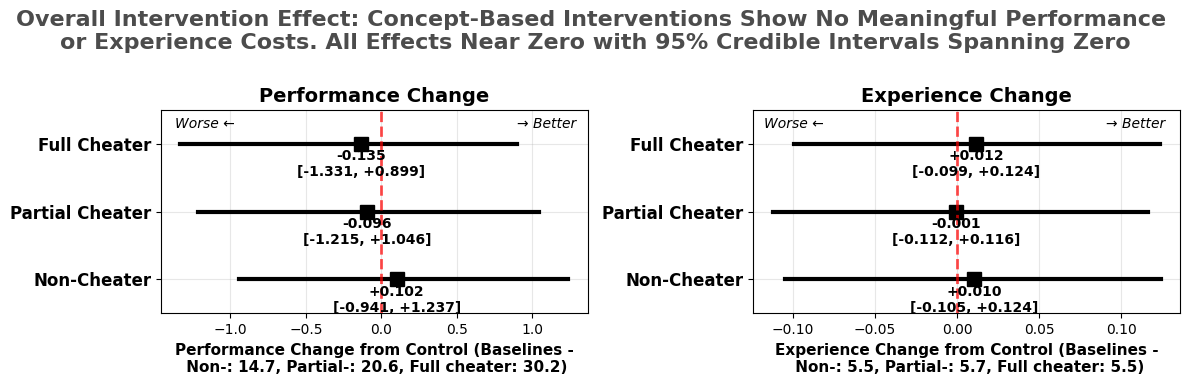

In [10]:
# ============================================================================
# FOREST PLOTS FOR PERFORMANCE AND EXPERIENCE (posterior)
# RQ2a.  Do the interventions affect performance and user experience?
# RQ2b.  Do the effects on performance and experience vary by concepts?
# ============================================================================

def create_overall_effects_plot():
    """Create forest plot using pre-calculated overall effects"""
    
    # Control baselines
    control_baselines = {
        'Performance': control_means_perf,  # [14.67, 20.60, 30.25]
        'Experience': control_means_exp     # [5.52, 5.69, 5.55]
    }
    
    # Outcomes and labels (reuse calculated effects)
    outcomes = [
        ('Performance', [
            (overall_perf_exp_results['perf_non']['mean'], overall_perf_exp_results['perf_non']['hdi']),
            (overall_perf_exp_results['perf_partial']['mean'], overall_perf_exp_results['perf_partial']['hdi']),
            (overall_perf_exp_results['perf_full']['mean'], overall_perf_exp_results['perf_full']['hdi'])
        ]),
        ('Experience', [
            (overall_perf_exp_results['exp_non']['mean'], overall_perf_exp_results['exp_non']['hdi']),
            (overall_perf_exp_results['exp_partial']['mean'], overall_perf_exp_results['exp_partial']['hdi']),
            (overall_perf_exp_results['exp_full']['mean'], overall_perf_exp_results['exp_full']['hdi'])
        ])
    ]
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    for idx, (outcome_name, group_effects) in enumerate(outcomes):
        ax = axes[idx]
        
        for i, (group, (mean, hdi)) in enumerate(zip(groups, group_effects)):
            # Plot effect with HDI
            ax.plot([hdi[0], hdi[1]], [i, i], color='black', linewidth=3)
            ax.plot(mean, i, 's', color='black', markersize=10)
            
            # Add value label
            ax.text(mean, i - 0.3, f'{mean:+.3f}\n[{hdi[0]:+.3f}, {hdi[1]:+.3f}]', 
                    ha='center', va='center', fontweight='bold', fontsize=10)
        
        ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax.set_yticks(range(len(groups)))
        ax.set_yticklabels(groups, fontsize=12, fontweight='bold')
        
        baseline_text = f"Non-: {control_baselines[outcome_name][0]:.1f}, " + \
                       f"Partial-: {control_baselines[outcome_name][1]:.1f}, " + \
                       f"Full cheater: {control_baselines[outcome_name][2]:.1f}"
        
        ax.set_xlabel(f'{outcome_name} Change from Control (Baselines -\n {baseline_text})', 
                     fontsize=11, fontweight='bold')
        ax.set_title(f'{outcome_name} Change', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, 2.5)
        
        # Add interpretation text
        xlim = ax.get_xlim()
        ax.text(xlim[0] * 0.8, 2.3, 'Worse ←', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
        ax.text(xlim[1] * 0.8, 2.3, '→ Better', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
    
    plt.suptitle('Overall Intervention Effect: Concept-Based Interventions Show No Meaningful Performance \nor Experience Costs. All Effects Near Zero with 95% Credible Intervals Spanning Zero', 
                 fontsize=16, fontweight='bold', color='black', alpha=0.7, y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.7)
    plt.show()

# Execute the plot
create_overall_effects_plot()

In [15]:
# ============================================================================
# 5.6.3.1. 4 PSYCHOLOGICAL MECHANISM VARIABLES 2 MODERATORS
# ============================================================================

print("5.6.3.1. Mediator and Moderator Variables")
print("-" * 45)

# 4 mediators (post-test, intervention-responsive)
mediator_vars = {
    'overall_need_satisfaction': 'Need Satisfaction',
    'overall_need_frustration': 'Need Frustration',
    'task_specific_self_efficacy': 'Self Efficacy', 
    'norm_perception': 'Norm Perception',
    'cognitive_discomfort': 'Discomfort'
}

# 2 moderators (baseline traits)
moderator_vars = {
    'word_creation_skill_level': 'Ability',
    'moral_disengagement': 'Moral Disengagement'
}

print("MEDIATORS (post-test):")
available_mediators = {}
for var, label in mediator_vars.items():
    if var in df.columns:
        print(f"✓ {label}: {df[var].notna().sum()} values")
        available_mediators[label] = (df[var] - df[var].mean()) / df[var].std()
    else:
        print(f"✗ {label}: NOT FOUND")

print(f"\nMODERATORS (baseline traits):")
available_moderators = {}
for var, label in moderator_vars.items():
    if var in df.columns:
        print(f"✓ {label}: {df[var].notna().sum()} values")
        available_moderators[label] = (df[var] - df[var].mean()) / df[var].std()
    else:
        print(f"✗ {label}: NOT FOUND")

# Mediator correlations
if len(available_mediators) >= 2:
    med_values = list(available_mediators.values())
    med_names = list(available_mediators.keys())
    med_corr = np.corrcoef(med_values)
    
    print(f"\nMEDIATOR CORRELATIONS:")
    print("-" * 25)
    for i, name1 in enumerate(med_names):
        for j, name2 in enumerate(med_names):
            if i < j:
                print(f"{name1} - {name2}: {med_corr[i,j]:.3f}")

print(f"\nMODEL SPECIFICATION:")
print("Mediators: Concepts → Mediators → Outcomes")
print("Moderators: Moderators × Concepts → Outcomes")

5.6.3.1. Mediator and Moderator Variables
---------------------------------------------
MEDIATORS (post-test):
✓ Need Satisfaction: 1232 values
✓ Need Frustration: 1232 values
✓ Self Efficacy: 1232 values
✓ Norm Perception: 1232 values
✓ Discomfort: 1232 values

MODERATORS (baseline traits):
✓ Ability: 1232 values
✓ Moral Disengagement: 1232 values

MEDIATOR CORRELATIONS:
-------------------------
Need Satisfaction - Need Frustration: -0.401
Need Satisfaction - Self Efficacy: 0.613
Need Satisfaction - Norm Perception: 0.487
Need Satisfaction - Discomfort: -0.373
Need Frustration - Self Efficacy: -0.196
Need Frustration - Norm Perception: 0.024
Need Frustration - Discomfort: 0.541
Self Efficacy - Norm Perception: 0.689
Self Efficacy - Discomfort: -0.186
Norm Perception - Discomfort: -0.034

MODEL SPECIFICATION:
Mediators: Concepts → Mediators → Outcomes
Moderators: Moderators × Concepts → Outcomes


In [16]:
# ============================================================================
# 5.6.3.2. PSYCHOLOGICAL MECHANISM MODELS 
# RQ3: How do concept-based interventions influence cheating behavior, performance and user experience?
# ============================================================================

print("\n" + "="*80)
print("5.6.3.2. Psychological Mechanism Models")
print("="*80)

print("RQ3: How do concept-based interventions influence cheating behavior?")
print("Analysis Strategy:")
print("1. PATH A: Concepts → Psychological Mechanisms")
print("2. PATH B: Psychological Mechanisms → Cheating Behavior (PRIMARY)")
print("3. PATH B: Psychological Mechanisms → Performance/Experience (VALIDATION)")
print("4. MODERATION: Individual Differences × Concepts → Cheating")

if len(available_mediators) >= 2 and len(available_moderators) >= 1:
    
    # Prepare mechanism and moderator data
    mechanism_keys = list(available_mediators.keys())
    moderator_keys = list(available_moderators.keys())
    
    print(f"\nPsychological Mechanisms ({len(mechanism_keys)}): {mechanism_keys}")
    print(f"Moderators ({len(moderator_keys)}): {moderator_keys}")
    
    # ========================================================================
    # MODEL 1: Concepts → Psychological Mechanisms (PATH A)
    # ========================================================================
    print("\nMODEL 1: Concepts → Psychological Mechanisms (PATH A)")
    
    with pm.Model() as mechanism_model:
        for mech_name, mech_values in available_mediators.items():
            key = mech_name.lower().replace(' ', '_').replace('disengagement', '')
            
            # Group-specific baselines
            baseline = pm.Normal(f'{key}_baseline', mu=0, sigma=0.5, shape=3)
            
            # Group-specific concept effects
            concept_effects = pm.Normal(f'{key}_concept_effects', mu=0, sigma=0.3, shape=(len(concepts), 3))
            
            # Message effects
            message_effects = pm.Normal(f'{key}_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
            
            # Linear predictor
            mu = baseline[y_cheating] + message_effects[message_codes]
            mu += pm.math.switch(concept_codes > 0, 
                                concept_effects[concept_codes - 1, y_cheating], 0)
            
            pm.Normal(f'{key}_obs', mu=mu, sigma=pm.HalfNormal(f'{key}_sigma', sigma=0.5), 
                     observed=mech_values)
    
    # ========================================================================
    # MODEL 2: Psychological Mechanisms → Cheating Behavior (PRIMARY ANALYSIS)
    # ========================================================================
    print("\nMODEL 2: Psychological Mechanisms → Cheating Behavior (PRIMARY)")
    
    with pm.Model() as mechanisms_to_cheating_model:
        # Control group baseline
        beta_partial_intercept = pm.Normal('beta_partial_intercept', mu=control_partial_logit, sigma=se_partial)
        beta_full_intercept = pm.Normal('beta_full_intercept', mu=control_full_logit, sigma=se_full)
        
        # Mechanism effects on cheating
        n_mechanisms = len(mechanism_keys)
        mech_effects_partial = pm.Normal('mech_effects_partial', mu=0, sigma=0.5, shape=n_mechanisms)
        mech_effects_full = pm.Normal('mech_effects_full', mu=0, sigma=0.5, shape=n_mechanisms)
        
        # Stack mechanisms
        mechanism_matrix = np.column_stack([available_mediators[key] for key in mechanism_keys])
        
        # Linear predictors
        eta_partial = beta_partial_intercept
        eta_full = beta_full_intercept
        
        for mech_idx in range(n_mechanisms):
            eta_partial += mechanism_matrix[:, mech_idx] * mech_effects_partial[mech_idx]
            eta_full += mechanism_matrix[:, mech_idx] * mech_effects_full[mech_idx]
        
        # Multinomial logistic probabilities
        logits = pm.math.stack([pm.math.zeros(eta_partial.shape), eta_partial, eta_full], axis=1)
        probs = pm.math.softmax(logits, axis=1)
        
        pm.Categorical('cheating_obs', p=probs, observed=y_cheating)
    
    # ========================================================================
    # MODEL 3: Psychological Mechanisms → Performance/Experience (VALIDATION)
    # ========================================================================
    print("\nMODEL 3: Psychological Mechanisms → Performance/Experience (VALIDATION)")

    with pm.Model() as mechanisms_to_outcomes_model:
        # Stack mechanisms
        mechanism_matrix = np.column_stack([available_mediators[key] for key in mechanism_keys])
        n_mechanisms = len(mechanism_keys)
        
        # Mechanism effects on outcomes BY CHEATING GROUP
        perf_mech_effects = pm.Normal('perf_mech_effects', mu=0, sigma=1.0, shape=(n_mechanisms, 3))
        exp_mech_effects = pm.Normal('exp_mech_effects', mu=0, sigma=0.3, shape=(n_mechanisms, 3))
        
        # Baselines by cheating group
        perf_baseline = pm.Normal('perf_baseline', mu=control_means_perf, sigma=2.0, shape=3)
        exp_baseline = pm.Normal('exp_baseline', mu=control_means_exp, sigma=0.3, shape=3)
        
        # Linear predictors
        mu_perf = perf_baseline[y_cheating]
        mu_exp = exp_baseline[y_cheating]
        
        for mech_idx in range(n_mechanisms):
            mu_perf += mechanism_matrix[:, mech_idx] * perf_mech_effects[mech_idx, y_cheating]
            mu_exp += mechanism_matrix[:, mech_idx] * exp_mech_effects[mech_idx, y_cheating]
        
        # Likelihoods
        pm.Normal('performance', mu=mu_perf, sigma=pm.HalfNormal('perf_sigma', sigma=5.0), observed=y_performance)
        pm.Normal('experience', mu=mu_exp, sigma=pm.HalfNormal('exp_sigma', sigma=0.5), observed=y_experience)
    
    # ========================================================================
    # MODEL 4: Moderation Analysis (Individual Differences × Concepts → Cheating)
    # ========================================================================
    print("\nMODEL 4: Individual Differences × Concepts → Cheating (MODERATION)")
    
    with pm.Model() as moderation_cheating_model:
        # Control baselines
        beta_partial_intercept = pm.Normal('beta_partial_intercept', mu=control_partial_logit, sigma=se_partial)
        beta_full_intercept = pm.Normal('beta_full_intercept', mu=control_full_logit, sigma=se_full)
        
        # Concept main effects
        concept_effects_partial = pm.Normal('concept_effects_partial', mu=-0.5, sigma=1.0, shape=len(concepts))
        concept_effects_full = pm.Normal('concept_effects_full', mu=-0.5, sigma=1.0, shape=len(concepts))
        
        # Moderator × Concept interactions
        n_moderators = len(moderator_keys)
        moderator_matrix = np.column_stack([available_moderators[key] for key in moderator_keys])
        
        moderation_partial = pm.Normal('moderation_partial', mu=0, sigma=0.5, shape=(n_moderators, len(concepts)))
        moderation_full = pm.Normal('moderation_full', mu=0, sigma=0.5, shape=(n_moderators, len(concepts)))
        
        # Linear predictors
        eta_partial = beta_partial_intercept
        eta_full = beta_full_intercept
        
        # Add concept effects
        eta_partial += pm.math.switch(concept_codes > 0, concept_effects_partial[concept_codes - 1], 0)
        eta_full += pm.math.switch(concept_codes > 0, concept_effects_full[concept_codes - 1], 0)
        
        # Add moderation effects
        for mod_idx in range(n_moderators):
            mod_effect_partial = pm.math.switch(concept_codes > 0, 
                moderator_matrix[:, mod_idx] * moderation_partial[mod_idx, concept_codes - 1], 0)
            mod_effect_full = pm.math.switch(concept_codes > 0,
                moderator_matrix[:, mod_idx] * moderation_full[mod_idx, concept_codes - 1], 0)
            
            eta_partial += mod_effect_partial
            eta_full += mod_effect_full
        
        # Multinomial logistic probabilities
        logits = pm.math.stack([pm.math.zeros(eta_partial.shape), eta_partial, eta_full], axis=1)
        probs = pm.math.softmax(logits, axis=1)
        
        pm.Categorical('cheating_obs', p=probs, observed=y_cheating)
    


5.6.3.2. Psychological Mechanism Models
RQ3: How do concept-based interventions influence cheating behavior?
Analysis Strategy:
1. PATH A: Concepts → Psychological Mechanisms
2. PATH B: Psychological Mechanisms → Cheating Behavior (PRIMARY)
3. PATH B: Psychological Mechanisms → Performance/Experience (VALIDATION)
4. MODERATION: Individual Differences × Concepts → Cheating

Psychological Mechanisms (5): ['Need Satisfaction', 'Need Frustration', 'Self Efficacy', 'Norm Perception', 'Discomfort']
Moderators (2): ['Ability', 'Moral Disengagement']

MODEL 1: Concepts → Psychological Mechanisms (PATH A)

MODEL 2: Psychological Mechanisms → Cheating Behavior (PRIMARY)

MODEL 3: Psychological Mechanisms → Performance/Experience (VALIDATION)

MODEL 4: Individual Differences × Concepts → Cheating (MODERATION)


In [35]:
# ========================================================================
# FIT ALL MODELS
# ========================================================================
print("\nFitting psychological mechanism models...")

# Fit PATH A model
with mechanism_model:
    trace_mechanisms = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

# Fit PRIMARY model (mechanisms → cheating)
with mechanisms_to_cheating_model:
    trace_mech_cheating = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

# Fit VALIDATION model (mechanisms → outcomes)
with mechanisms_to_outcomes_model:
    trace_mech_outcomes = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

# Fit MODERATION model
# with moderation_cheating_model:
#     trace_moderation = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

print("All models fitted successfully!")

# ========================================================================
# RESULTS SUMMARY FOR RQ3
# ========================================================================
print("\n" + "="*80)
print("RQ3 RESULTS SUMMARY")
print("="*80)

print("✓ PATH A: Which concepts activate which psychological mechanisms?")
print("✓ PATH B (PRIMARY): Which psychological mechanisms reduce cheating?")
print("✓ PATH B (VALIDATION): How mechanisms affect performance/experience (confirms measures)")
print("✓ MODERATION: Do individual differences moderate concept effectiveness?")
    
print("\nThis comprehensive analysis reveals the psychological pathways through which")
print("concept-based interventions influence cheating behavior.")


Fitting psychological mechanism models...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [need_satisfaction_baseline, need_satisfaction_concept_effects, need_satisfaction_message_effects, need_satisfaction_sigma, need_frustration_baseline, need_frustration_concept_effects, need_frustration_message_effects, need_frustration_sigma, self_efficacy_baseline, self_efficacy_concept_effects, self_efficacy_message_effects, self_efficacy_sigma, norm_perception_baseline, norm_perception_concept_effects, norm_perception_message_effects, norm_perception_sigma, discomfort_baseline, discomfort_concept_effects, discomfort_message_effects, discomfort_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 22 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mech_effects_partial, mech_effects_full]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [perf_mech_effects, exp_mech_effects, perf_baseline, exp_baseline, perf_sigma, exp_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.


All models fitted successfully!

RQ3 RESULTS SUMMARY
✓ PATH A: Which concepts activate which psychological mechanisms?
✓ PATH B (PRIMARY): Which psychological mechanisms reduce cheating?
✓ PATH B (VALIDATION): How mechanisms affect performance/experience (confirms measures)
✓ MODERATION: Do individual differences moderate concept effectiveness?

This comprehensive analysis reveals the psychological pathways through which
concept-based interventions influence cheating behavior.


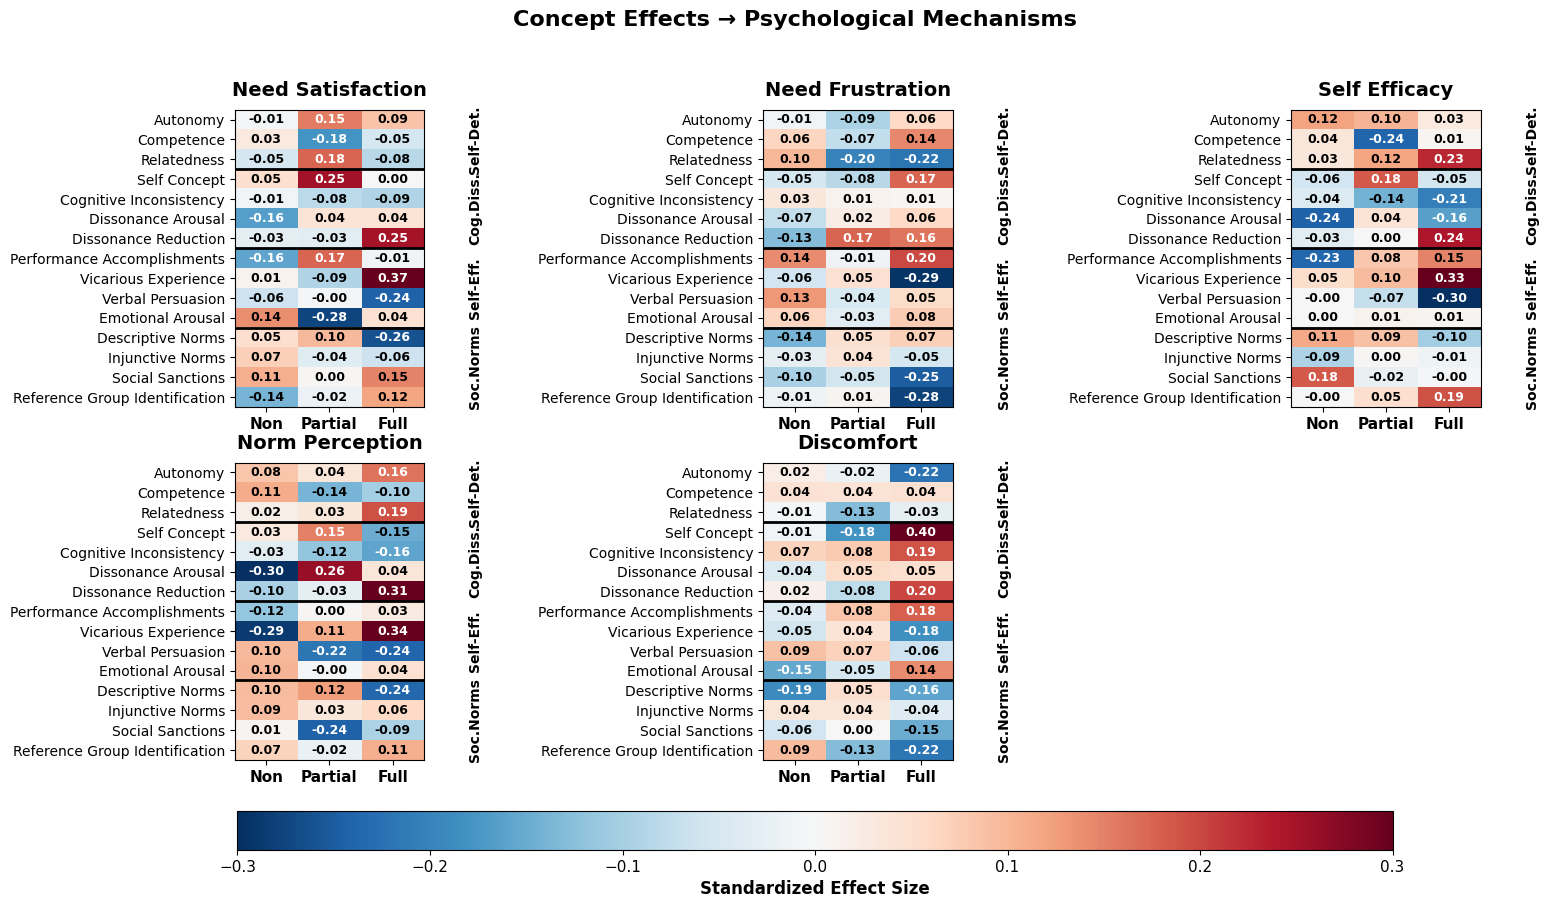


STRONGEST CONCEPT EFFECTS (|effect| > 0.15):

NEED SATISFACTION:
  Vicarious Experience           Full            +0.375
  Emotional Arousal              Partial         -0.276
  Descriptive Norms              Full            -0.261
  Self Concept                   Partial         +0.252
  Dissonance Reduction           Full            +0.249
  Verbal Persuasion              Full            -0.243
  Competence                     Partial         -0.180
  Relatedness                    Partial         +0.175
  Performance Accomplishments    Partial         +0.174
  Dissonance Arousal             Non             -0.164
  Performance Accomplishments    Non             -0.157
  Autonomy                       Partial         +0.155

NEED FRUSTRATION:
  Vicarious Experience           Full            -0.295
  Reference Group Identification Full            -0.278
  Social Sanctions               Full            -0.246
  Relatedness                    Full            -0.220
  Relatedness      

In [40]:
# ============================================================================
# PATH A: HEATMAP: ALL CONCEPTS → PSYCHOLOGICAL MECHANISMS
# ============================================================================

def create_concept_mediator_heatmap():
    """Create heatmap showing which concepts affect which mediators by cheating group - FIXED FOR 5 MEDIATORS"""
    
    # Extract concept effects for each mediator
    concept_mediator_effects = {}
    for i, med_name in enumerate(mechanism_keys): 
        key = med_name.lower().replace(' ', '_').replace('disengagement', '')
        concept_effects = trace_mechanisms.posterior[f'{key}_concept_effects'].values.reshape(-1, len(concepts), 3)
        concept_mediator_effects[med_name] = concept_effects.mean(axis=0)  # Mean across MCMC samples
    
    # FIXED: Calculate subplot layout for 5 mediators
    n_mediators = len(mechanism_keys)
    if n_mediators <= 4:
        nrows, ncols = 2, 2
    elif n_mediators == 5:
        nrows, ncols = 2, 3  # 2x3 grid, last subplot will be empty
    elif n_mediators == 6:
        nrows, ncols = 2, 3
    else:
        nrows, ncols = 3, 3  # For more than 6
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))
    axes = axes.flatten()
    
    groups = ['Non', 'Partial', 'Full']
    
    # Theory groupings for concept ordering
    theory_order = [
        'autonomy', 'competence', 'relatedness',  # Self-Determination
        'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # Cognitive Dissonance
        'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # Self-Efficacy
        'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # Social Norms
    ]
    
    concept_labels = [c.replace('_', ' ').title() for c in theory_order]
    
    for med_idx, med_name in enumerate(mechanism_keys): 
        ax = axes[med_idx]
        
        # Get effects for this mediator (concepts × groups)
        effects = concept_mediator_effects[med_name]  # Shape: (15 concepts, 3 groups)
        
        # Create heatmap data
        heatmap_data = np.zeros((len(theory_order), 3))
        concepts_list = list(concepts)  # Convert Index to list
        for i, concept in enumerate(theory_order):
            if concept in concepts_list:
                concept_idx = concepts_list.index(concept)
                heatmap_data[i, :] = effects[concept_idx, :]
        
        # Plot heatmap
        im = ax.imshow(heatmap_data, cmap='RdBu_r', aspect='auto', vmin=-0.3, vmax=0.3)
        
        # Add text annotations
        for i in range(len(theory_order)):
            for j in range(3):
                value = heatmap_data[i, j]
                text_color = 'white' if abs(value) > 0.15 else 'black'
                ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                       color=text_color, fontweight='bold', fontsize=9)
        
        # Formatting
        ax.set_xticks(range(3))
        ax.set_xticklabels(groups, fontsize=11, fontweight='bold')
        ax.set_yticks(range(len(theory_order)))
        ax.set_yticklabels(concept_labels, fontsize=10)
        ax.set_title(f'{med_name}', fontsize=14, fontweight='bold', pad=10)
        
        # Add theory separators
        theory_boundaries = [2.5, 6.5, 10.5]  # Between theory groups
        for boundary in theory_boundaries:
            ax.axhline(boundary, color='black', linewidth=2)
        
        # Add theory labels on the right
        theory_positions = [1, 4.5, 8.5, 12.5]
        theory_names = ['Self-Det.', 'Cog.Diss.', 'Self-Eff.', 'Soc.Norms']
        for pos, name in zip(theory_positions, theory_names):
            ax.text(3.2, pos, name, rotation=90, va='center', ha='left', 
                   fontsize=10, fontweight='bold')
    
    # FIXED: Hide empty subplots if we have fewer than the grid size
    for empty_idx in range(n_mediators, len(axes)):
        axes[empty_idx].set_visible(False)
    
    # Add colorbar - use only the visible axes
    visible_axes = axes[:n_mediators]
    cbar = fig.colorbar(im, ax=visible_axes, orientation='horizontal', 
                       fraction=0.05, pad=0.08, aspect=30)
    cbar.set_label('Standardized Effect Size', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=11)
    
    plt.suptitle('Concept Effects → Psychological Mechanisms',
                fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.2)
    plt.show()
    
    # Print strongest effects
    print("\nSTRONGEST CONCEPT EFFECTS (|effect| > 0.15):")
    print("="*60)
    
    for med_name in mechanism_keys: 
        effects = concept_mediator_effects[med_name]
        print(f"\n{med_name.upper()}:")
        
        strong_effects = []
        concepts_list = list(concepts)  # Convert Index to list
        for i, concept in enumerate(theory_order):
            if concept in concepts_list:
                concept_idx = concepts_list.index(concept)
                for j, group in enumerate(groups):
                    effect = effects[concept_idx, j]
                    if abs(effect) > 0.15:
                        strong_effects.append((concept.replace('_', ' ').title(), 
                                             group, effect))
        
        if strong_effects:
            for concept_name, group, effect in sorted(strong_effects, key=lambda x: abs(x[2]), reverse=True):
                print(f"  {concept_name:<30} {group:<15} {effect:+.3f}")
        else:
            print("  No effects > |0.15|")

# Execute the heatmap
create_concept_mediator_heatmap()

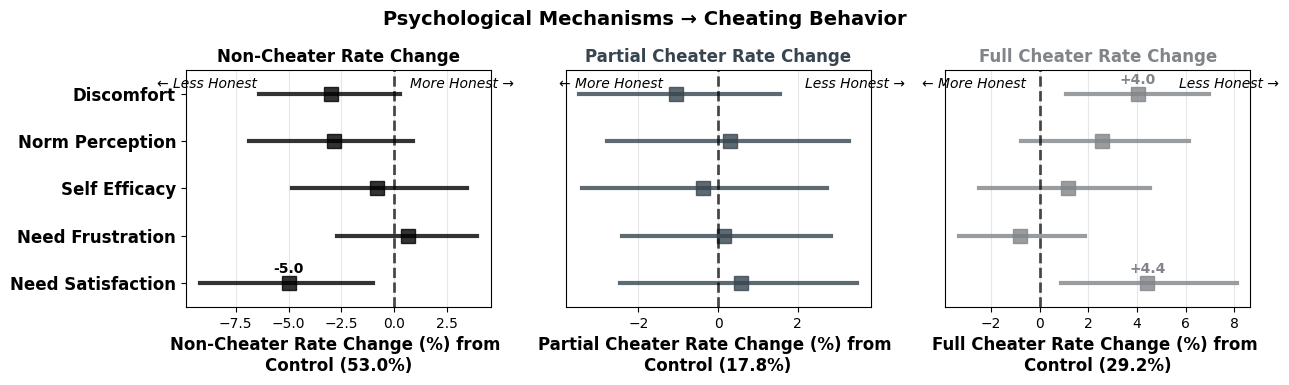


PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR RESULTS
Mechanism            Non-Cheater               Partial Cheater           Full Cheater             
-----------------------------------------------------------------------------------------------
Need Satisfaction    -5.0% [-9.2, -1.0]        +0.6% [-2.5, +3.5]        +4.4% [+0.9, +8.1]       
Need Frustration     +0.6% [-2.7, +3.9]        +0.2% [-2.4, +2.8]        -0.8% [-3.3, +1.9]       
Self Efficacy        -0.8% [-4.8, +3.4]        -0.4% [-3.4, +2.7]        +1.2% [-2.5, +4.5]       
Norm Perception      -2.9% [-6.9, +0.9]        +0.3% [-2.8, +3.3]        +2.6% [-0.8, +6.1]       
Discomfort           -3.0% [-6.4, +0.3]        -1.1% [-3.5, +1.6]        +4.0% [+1.1, +6.9]       

KEY FINDINGS:
✓ Positive values = increase in that cheating category
✓ Negative values = decrease in that cheating category
✓ Effects with HDI excluding zero are statistically reliable


In [44]:
# ================================================================================
# PATH B: FOREST PLOT: PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR (PRIMARY ANALYSIS)
# ================================================================================

def create_mechanisms_cheating_forest_plot():
    """FIXED: Forest plot showing how psychological mechanisms affect cheating behavior"""
    
    # Extract mechanism effects on cheating (log-odds scale)
    mech_effects_partial = trace_mech_cheating.posterior['mech_effects_partial'].values.reshape(-1, len(mechanism_keys))
    mech_effects_full = trace_mech_cheating.posterior['mech_effects_full'].values.reshape(-1, len(mechanism_keys))
    
    # Get baseline intercepts
    beta_partial_intercept = trace_mech_cheating.posterior['beta_partial_intercept'].values.flatten()
    beta_full_intercept = trace_mech_cheating.posterior['beta_full_intercept'].values.flatten()
    
    mechanism_results = []
    
    for mech_idx, mech_name in enumerate(mechanism_keys):
        # For a 1 standard deviation increase in the mechanism
        mechanism_change = 1.0  # 1 SD increase
        
        # BASELINE probabilities (mechanism = 0)
        baseline_logits = np.column_stack([
            np.zeros(len(beta_partial_intercept)),  # Non-cheater (reference)
            beta_partial_intercept,                  # Partial cheater
            beta_full_intercept                      # Full cheater
        ])
        baseline_probs = np.exp(baseline_logits) / np.exp(baseline_logits).sum(axis=1, keepdims=True)
        
        # NEW probabilities (mechanism = +1 SD)
        new_logits = np.column_stack([
            np.zeros(len(beta_partial_intercept)),  # Non-cheater (reference)
            beta_partial_intercept + mechanism_change * mech_effects_partial[:, mech_idx],
            beta_full_intercept + mechanism_change * mech_effects_full[:, mech_idx]
        ])
        new_probs = np.exp(new_logits) / np.exp(new_logits).sum(axis=1, keepdims=True)
        
        # Calculate probability DIFFERENCES (percentage points)
        non_prob_change = (new_probs[:, 0] - baseline_probs[:, 0]) * 100
        partial_prob_change = (new_probs[:, 1] - baseline_probs[:, 1]) * 100  
        full_prob_change = (new_probs[:, 2] - baseline_probs[:, 2]) * 100
        
        mechanism_results.append({
            'mechanism': mech_name,
            'non_mean': non_prob_change.mean(),
            'non_hdi': az.hdi(non_prob_change, hdi_prob=0.95),
            'partial_mean': partial_prob_change.mean(), 
            'partial_hdi': az.hdi(partial_prob_change, hdi_prob=0.95),
            'full_mean': full_prob_change.mean(),
            'full_hdi': az.hdi(full_prob_change, hdi_prob=0.95)
        })
    
    # FIXED: Dynamic figure size based on number of mechanisms
    fig_height = max(4, len(mechanism_keys) * 0.6)
    fig, axes = plt.subplots(1, 3, figsize=(13, fig_height))
    categories = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    result_keys = ['non', 'partial', 'full']
    colors = ['#000000', '#36454F', '#818589']
    
    for idx, (category, key, color) in enumerate(zip(categories, result_keys, colors)):
        ax = axes[idx]
        
        y_positions = np.arange(len(mechanism_keys))
        
        for i, result in enumerate(mechanism_results):
            mean = result[f'{key}_mean']
            hdi = result[f'{key}_hdi']
            
            # Plot HDI and mean
            ax.plot([hdi[0], hdi[1]], [i, i], color=color, linewidth=3, alpha=0.8)
            ax.plot(mean, i, 's', color=color, markersize=10, alpha=0.8)
            
            # Add value label for significant effects
            if hdi[0] > 0 or hdi[1] < 0:
                ax.text(mean, i + 0.15, f'{mean:+.1f}', ha='center', va='bottom', 
                       fontweight='bold', fontsize=10, color=color)
        
        # Formatting
        ax.axvline(0, color='black', linestyle='--', alpha=0.7, linewidth=2)
        
        if idx == 0:
            ax.set_yticks(y_positions)
            ax.set_yticklabels(mechanism_keys, fontsize=12, fontweight='bold')
        else:
            ax.set_yticks([])
        
        # Get control baseline for this category
        if category == 'Non-Cheater':
            control_baseline = control_probs[:, 0].mean() * 100
        elif category == 'Partial Cheater':
            control_baseline = control_probs[:, 1].mean() * 100
        else:  # Full Cheater
            control_baseline = control_probs[:, 2].mean() * 100
            
        ax.set_xlabel(f'{category} Rate Change (%) from \nControl ({control_baseline:.1f}%)', fontsize=12, fontweight='bold')
        ax.set_title(f'{category} Rate Change', fontweight='bold', fontsize=12, color=color)
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_ylim(-0.5, len(mechanism_keys) - 0.5)
        
        # Add interpretation text
        xlim = ax.get_xlim()
        if category == 'Non-Cheater':
            ax.text(xlim[0] * 0.9, len(mechanism_keys) - 0.8, '← Less Honest', ha='center', va='center', 
                    fontsize=10, style='italic', color='black')
            ax.text(xlim[1] * 0.7, len(mechanism_keys) - 0.8, 'More Honest →', ha='center', va='center', 
                    fontsize=10, style='italic', color='black')
        else:
            ax.text(xlim[0] * 0.7, len(mechanism_keys) - 0.8, '← More Honest', ha='center', va='center', 
                    fontsize=10, style='italic', color='black')
            ax.text(xlim[1] * 0.9, len(mechanism_keys) - 0.8, 'Less Honest →', ha='center', va='center', 
                    fontsize=10, style='italic', color='black')
    
    plt.suptitle('Psychological Mechanisms → Cheating Behavior', 
                 fontsize=14, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()
    
    # Print results
    print("\n" + "="*80)
    print("PSYCHOLOGICAL MECHANISMS → CHEATING BEHAVIOR RESULTS")
    print("="*80)
    
    print(f"{'Mechanism':<20} {'Non-Cheater':<25} {'Partial Cheater':<25} {'Full Cheater':<25}")
    print("-"*95)
    
    for result in mechanism_results:
        non_str = f"{result['non_mean']:+.1f}% [{result['non_hdi'][0]:+.1f}, {result['non_hdi'][1]:+.1f}]"
        partial_str = f"{result['partial_mean']:+.1f}% [{result['partial_hdi'][0]:+.1f}, {result['partial_hdi'][1]:+.1f}]"
        full_str = f"{result['full_mean']:+.1f}% [{result['full_hdi'][0]:+.1f}, {result['full_hdi'][1]:+.1f}]"
        
        print(f"{result['mechanism']:<20} {non_str:<25} {partial_str:<25} {full_str:<25}")
    
    print(f"\nKEY FINDINGS:")
    print("✓ Positive values = increase in that cheating category")
    print("✓ Negative values = decrease in that cheating category") 
    print("✓ Effects with HDI excluding zero are statistically reliable")
    
    return mechanism_results

# Execute the plot
mechanisms_cheating_results = create_mechanisms_cheating_forest_plot()

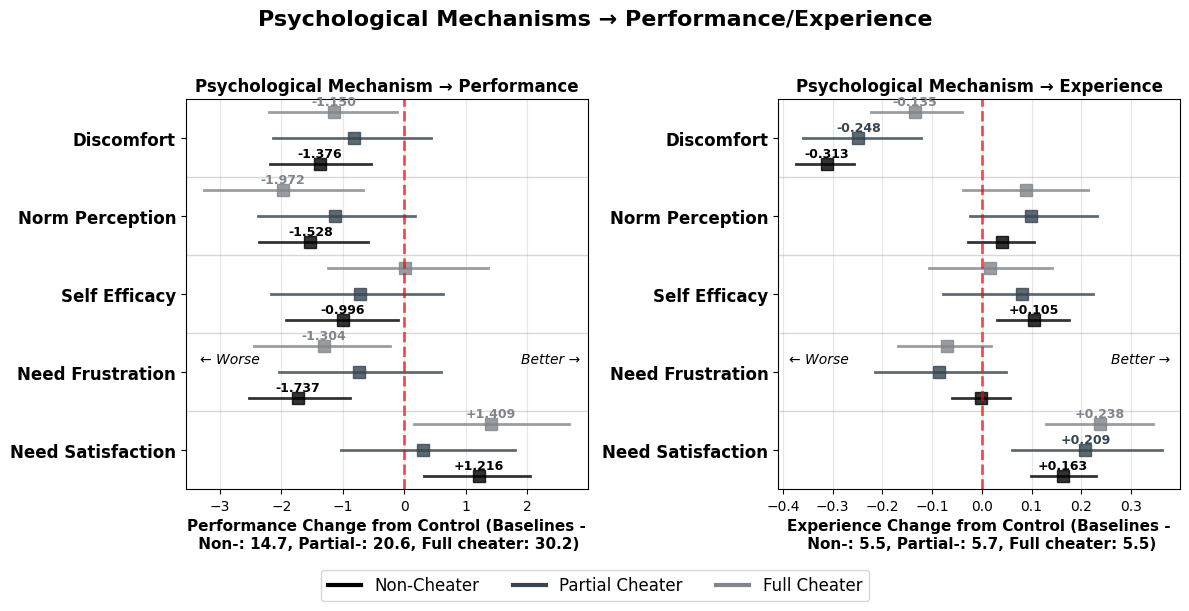


PATH B: MEDIATORS → OUTCOMES BY CHEATING GROUP

Performance:
Mediator             Group           Mean     95% HDI             
------------------------------------------------------------
Need Satisfaction    Non             +1.216 [+0.321, +2.050]
Need Satisfaction    Partial         +0.304 [-1.031, +1.806]
Need Satisfaction    Full            +1.409 [+0.149, +2.681]
Need Frustration     Non             -1.737 [-2.526, -0.882]
Need Frustration     Partial         -0.741 [-2.044, +0.598]
Need Frustration     Full            -1.304 [-2.452, -0.226]
Self Efficacy        Non             -0.996 [-1.919, -0.106]
Self Efficacy        Partial         -0.722 [-2.162, +0.621]
Self Efficacy        Full            +0.013 [-1.247, +1.353]
Norm Perception      Non             -1.528 [-2.362, -0.598]
Norm Perception      Partial         -1.120 [-2.378, +0.172]
Norm Perception      Full            -1.972 [-3.258, -0.669]
Discomfort           Non             -1.376 [-2.186, -0.542]
Discomfort       

In [29]:
# ============================================================================
# PATH B: FOREST PLOT: Psychological Mechanisms → Performance and Experience
# ============================================================================

def create_mechanisms_perf_exp_forest_plot():
    """Forest plot showing how psychological mechanisms affect performance and experience by cheating group"""
    
    # Extract PATH B effects from stratified validation model
    perf_med_effects = trace_mech_outcomes.posterior['perf_mech_effects'].values.reshape(-1, len(mechanism_keys), 3)
    exp_med_effects = trace_mech_outcomes.posterior['exp_mech_effects'].values.reshape(-1, len(mechanism_keys), 3)
    
    control_baselines = {
        'Performance': control_means_perf,  # [14.67, 20.60, 30.25]
        'Experience': control_means_exp     # [5.52, 5.69, 5.55]
    }
    
    outcomes = [
        ('Performance', perf_med_effects),
        ('Experience', exp_med_effects)
    ]
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    # Dynamic figure size based on number of mechanisms
    fig_height = max(6, len(mechanism_keys) * 1.2)
    fig, axes = plt.subplots(1, 2, figsize=(12, fig_height))
    
    for idx, (outcome_name, med_effects) in enumerate(outcomes):
        ax = axes[idx]
        
        # Colors for each group
        colors = ['#000000', '#36454F', '#818589']
        
        for j, med_name in enumerate(mechanism_keys):
            for i, (group, group_idx) in enumerate(zip(groups, [0, 1, 2])):
                # Proper y positioning: each mediator gets 3 positions (one per group)
                y_pos = j * 3 + i
                effects = med_effects[:, j, group_idx]
                
                mean = effects.mean()
                hdi = az.hdi(effects, hdi_prob=0.95)
                
                # Plot effect with CI
                ax.plot([hdi[0], hdi[1]], [y_pos, y_pos], color=colors[i], linewidth=2, alpha=0.8)
                ax.plot(mean, y_pos, 's', color=colors[i], markersize=8, alpha=0.8)
                
                # Add value label for significant effects (HDI doesn't cross 0)
                if hdi[0] > 0 or hdi[1] < 0:
                    ax.text(mean, y_pos + 0.15, f'{mean:+.3f}', ha='center', va='bottom', 
                           fontweight='bold', fontsize=9, color=colors[i])
        
        # Formatting
        ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add horizontal lines to separate mediators
        for j in range(1, len(mechanism_keys)):
            ax.axhline(j * 3 - 0.5, color='gray', linestyle='-', alpha=0.3, linewidth=1)
        
        # Y-axis: mediator labels at center of each group
        y_ticks = [j * 3 + 1 for j in range(len(mechanism_keys))]  # Center position for each mediator
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(mechanism_keys, fontsize=12, fontweight='bold')
        ax.set_ylim(-0.5, len(mechanism_keys) * 3 - 0.5)
        
        baseline_text = f"Non-: {control_baselines[outcome_name][0]:.1f}, " + \
                       f"Partial-: {control_baselines[outcome_name][1]:.1f}, " + \
                       f"Full cheater: {control_baselines[outcome_name][2]:.1f}"
        
        ax.set_xlabel(f'{outcome_name} Change from Control (Baselines -\n {baseline_text})', 
                     fontsize=11, fontweight='bold')
        ax.set_title(f'Psychological Mechanism → {outcome_name}', fontweight='bold', fontsize=12)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add interpretation text
        xlim = ax.get_xlim()
        ax.text(xlim[0] * 0.8, len(mechanism_keys) - 0.5, '← Worse', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
        ax.text(xlim[1] * 0.8, len(mechanism_keys) - 0.5, 'Better →', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], color=color, lw=3, label=group) 
                      for color, group in zip(['#000000', '#36454F', '#818589'], groups)]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
              ncol=3, fontsize=12)
    
    plt.suptitle('Psychological Mechanisms → Performance/Experience', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8, bottom=0.15)
    plt.show()
    
    # Print results
    print("\n" + "="*80)
    print("PATH B: MEDIATORS → OUTCOMES BY CHEATING GROUP")
    print("="*80)
    
    for outcome_name, med_effects in outcomes:
        print(f"\n{outcome_name}:")
        print(f"{'Mediator':<20} {'Group':<15} {'Mean':<8} {'95% HDI':<20}")
        print("-"*60)
        
        for j, med_name in enumerate(mechanism_keys):
            for i, group in enumerate(['Non', 'Partial', 'Full']):
                effects = med_effects[:, j, i]
                mean = effects.mean()
                hdi = az.hdi(effects, hdi_prob=0.95)
                
                print(f"{med_name:<20} {group:<15} {mean:+.3f} [{hdi[0]:+.3f}, {hdi[1]:+.3f}]")



# Execute the plot
create_mechanisms_perf_exp_forest_plot()

In [ ]:
# ============================================================================
# FOREST PLOT: OVERALL MODERATION EFFECTS (Perceived ability and moral disengagement)
# ============================================================================

def create_overall_moderation_forest_plot():
    """Forest plot showing overall moderation effects (averaged across concepts)"""
    
    # Extract moderation effects and calculate overall effects
    perf_mod = trace_moderation.posterior['perf_moderation'].values.reshape(-1, len(moderator_keys), len(concepts), 3)
    exp_mod = trace_moderation.posterior['exp_moderation'].values.reshape(-1, len(moderator_keys), len(concepts), 3)
    
    # Average across all concepts for overall effect
    perf_overall = perf_mod.mean(axis=2)  # Shape: (samples, moderators, groups)
    exp_overall = exp_mod.mean(axis=2)
    
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    colors = ['#000000', '#36454F', '#818589']
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for idx, (outcome, effects) in enumerate([('Performance', perf_overall), ('Experience', exp_overall)]):
        ax = axes[idx]
        
        for j, mod_name in enumerate(moderator_keys):
            for i, group in enumerate(groups):
                y_pos = j * 3 + i
                samples = effects[:, j, i]
                
                mean = samples.mean()
                hdi = az.hdi(samples, hdi_prob=0.95)
                
                # Plot HDI and mean
                ax.plot([hdi[0], hdi[1]], [y_pos, y_pos], color=colors[i], linewidth=3)
                ax.plot(mean, y_pos, 's', color=colors[i], markersize=10)
                
                # Add value label
                # ax.text(mean, y_pos - 0.2, f'{mean:+.3f}\n[{hdi[0]:+.3f},{hdi[1]:+.3f}]', 
                        # ha='center', va='center', fontweight='bold', fontsize=10)
        
        # Formatting
        ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax.axhline(2.5, color='gray', alpha=0.5, linewidth=1)  # Separate moderators
        
        # Y-labels
        y_ticks = [1, 4]  # Center of each moderator group
        y_labels = moderator_keys
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels, fontsize=12, fontweight='bold')
        
        ax.set_xlabel(f'{outcome} Moderation Effect (95% HDI)', fontweight='bold')
        ax.set_title(f'Overall Moderator Effect → {outcome}', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_ylim(-0.5, 5.5)
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], color=color, lw=3, label=group) 
                      for color, group in zip(colors, groups)]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    plt.suptitle('Overall Moderation Effects: No Significant Moderation by Perceived Ability or Moral Disengagement in Intervention', 
                 fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8, bottom=0.2)
    plt.show()

create_overall_moderation_forest_plot()

In [ ]:
# ============================================================================
# LLM-BASED COMPREHENSION SCORING AND CSV EXPORT
# ============================================================================

import pandas as pd
import numpy as np
from openai import OpenAI
from dotenv import load_dotenv
import os
import time

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI()

# Concept definitions for scoring
CONCEPT_DEFINITIONS = {
    'autonomy': "The need to feel volitional and self-directed in one's actions, having choice and control over decisions.",
    'competence': "The need to feel effective and capable of achieving desired outcomes and mastering challenges.",
    'relatedness': "The need to feel connected to others and experience a sense of belonging and attachment.",
    'cognitive_inconsistency': "The psychological discomfort arising from holding contradictory beliefs, values, or attitudes simultaneously.",
    'self_concept': "One's perception and evaluation of their own identity, abilities, and characteristics.",
    'dissonance_arousal': "The activation of psychological tension when actions conflict with beliefs or values.",
    'dissonance_reduction': "Strategies to reduce psychological discomfort by changing attitudes, beliefs, or behaviors.",
    'performance_accomplishments': "Past successful experiences that build confidence in one's ability to perform tasks.",
    'vicarious_experience': "Learning and building confidence by observing others successfully perform tasks.",
    'verbal_persuasion': "Encouragement and feedback from others that influences self-confidence and motivation.",
    'emotional_arousal': "Physiological and emotional states that influence perception of one's capabilities.",
    'descriptive_norms': "Perceptions of what behaviors are typically performed by others in similar situations.",
    'injunctive_norms': "Perceptions of what behaviors are approved or disapproved by others.",
    'social_sanctions': "Consequences (positive or negative) imposed by others for conforming to or violating social expectations.",
    'reference_group_identification': "The sense of belonging and identity derived from membership in a particular social group."
}

def create_comprehension_prompt(concept: str, response: str) -> str:
    """Create prompt for scoring message comprehension alignment"""
    concept_def = CONCEPT_DEFINITIONS.get(concept, "Unknown concept")
    
    return f"""Rate how well this participant understood the message about {concept}.

Concept Definition: {concept_def}

Participant Response: "{response}"

Score 0-4 where:
0 = No understanding (empty, irrelevant, or completely incorrect)
1 = Minimal understanding (vague or mostly incorrect)
2 = Basic understanding (partially correct but incomplete)
3 = Good understanding (mostly correct with minor gaps)
4 = Excellent understanding (accurate and complete)

Respond with only the number (0-4)."""

def score_comprehension_batch(df: pd.DataFrame, batch_size: int = 10) -> pd.DataFrame:
    """Score comprehension using LLM in batches"""
    
    # Filter intervention participants with responses
    intervention_mask = (df['concept'] != 'control') & df['message_comprehend'].notna()
    to_score = df[intervention_mask].copy()
    
    print(f"Scoring {len(to_score)} responses in batches of {batch_size}...")
    
    # Initialize results
    df['comprehension_score'] = 0
    df['comprehension_status'] = 'control'
    
    scores = []
    statuses = []
    
    # Process in batches
    for i in range(0, len(to_score), batch_size):
        batch = to_score.iloc[i:i+batch_size]
        batch_scores = []
        batch_statuses = []
        
        for _, row in batch.iterrows():
            concept = row['concept']
            response = str(row['message_comprehend'])[:300]  # Truncate long responses
            
            if pd.isna(response) or response.strip() == "" or response.strip().lower() == "nan":
                batch_scores.append(0)
                batch_statuses.append('empty')
                continue
            
            prompt = create_comprehension_prompt(concept, response)
            
            try:
                response_obj = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=5,
                    temperature=0
                )
                
                score_text = response_obj.choices[0].message.content.strip()
                score = int(''.join(filter(str.isdigit, score_text)))
                score = max(0, min(4, score))  # Ensure 0-4 range
                
                batch_scores.append(score)
                batch_statuses.append('success')
                
            except Exception as e:
                print(f"Error scoring response: {e}")
                batch_scores.append(0)
                batch_statuses.append('error')
            
            time.sleep(0.1)  # Rate limiting
        
        scores.extend(batch_scores)
        statuses.extend(batch_statuses)
        
        print(f"Batch {i//batch_size + 1}/{(len(to_score)-1)//batch_size + 1} completed")
    
    # Assign scores back to dataframe
    df.loc[intervention_mask, 'comprehension_score'] = scores
    df.loc[intervention_mask, 'comprehension_status'] = statuses
    
    # Summary statistics
    success_scores = [s for s, st in zip(scores, statuses) if st == 'success']
    if success_scores:
        print(f"\nScoring complete:")
        print(f"Success rate: {len(success_scores)}/{len(scores)} ({len(success_scores)/len(scores):.1%})")
        print(f"Mean score: {np.mean(success_scores):.2f}")
        print(f"Score distribution: {pd.Series(success_scores).value_counts().sort_index().to_dict()}")
    
    return df

# ============================================================================
# EXECUTE SCORING AND SAVE TO CSV
# ============================================================================

# Score comprehension
df_scored = score_comprehension_batch(df, batch_size=10)

# Save results to CSV
output_file = "final_dataset_with_comprehension_scores.csv"
df_scored.to_csv(output_file, index=False)

print(f"\nResults saved to: {output_file}")
print(f"Columns added: comprehension_score, comprehension_status")

# Quick validation
intervention_data = df_scored[df_scored['concept'] != 'control']
print(f"\nValidation:")
print(f"Total intervention participants: {len(intervention_data)}")
print(f"Participants with comprehension scores > 0: {(intervention_data['comprehension_score'] > 0).sum()}")
print(f"Success rate: {(intervention_data['comprehension_status'] == 'success').mean():.1%}")

print("\nReady for mediation analysis with comprehension scores!")

COMPREHENSION SCORES BY CONCEPT
                                 N  Mean    SD  Score_0  Score_3+  Pct_Good
concept                                                                    
verbal_persuasion               76  1.97  1.03        4        35      46.1
relatedness                     78  1.87  0.94        1        29      37.2
performance_accomplishments     77  1.86  0.87        0        24      31.2
competence                      77  1.66  0.84        1        17      22.1
autonomy                        76  1.64  0.83        0        17      22.4
emotional_arousal               77  1.57  0.80        1        14      18.2
vicarious_experience            78  1.55  0.77        1        12      15.4
social_sanctions                78  1.53  0.78        2        12      15.4
reference_group_identification  77  1.52  0.75        1        11      14.3
dissonance_arousal              77  1.48  0.84        1        16      20.8
self_concept                    76  1.36  0.65        0 

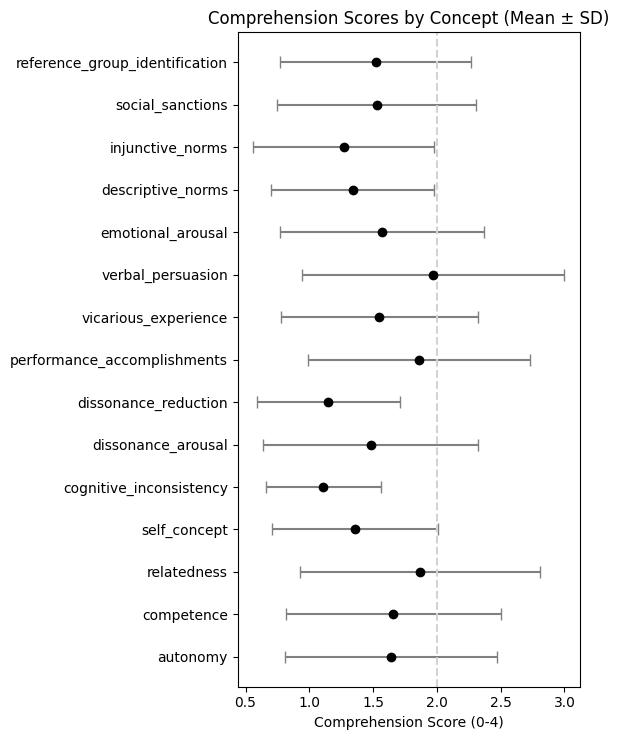

In [28]:
# ============================================================================
# MEAN COMPREHENSION SCORES BY CONCEPT
# ============================================================================

# Load scored data and analyze comprehension by concept
df_scored = pd.read_csv("final_dataset_with_comprehension_scores.csv")

# Comprehension scores by concept
concept_scores = df_scored[df_scored['concept'] != 'control'].groupby('concept')['comprehension_score'].agg([
    'count', 'mean', 'std', 
    lambda x: (x == 0).sum(),  # No understanding
    lambda x: (x >= 3).sum()   # Good+ understanding
]).round(2)

concept_scores.columns = ['N', 'Mean', 'SD', 'Score_0', 'Score_3+']
concept_scores['Pct_Good'] = (concept_scores['Score_3+'] / concept_scores['N'] * 100).round(1)

# Sort by mean score
concept_scores_sorted = concept_scores.sort_values('Mean', ascending=False)

print("COMPREHENSION SCORES BY CONCEPT")
print("="*60)
print(concept_scores_sorted.to_string())

# Quick summary
print(f"\nSUMMARY:")
print(f"Best understood: {concept_scores_sorted.index[0]} (M={concept_scores_sorted.iloc[0]['Mean']})")
print(f"Worst understood: {concept_scores_sorted.index[-1]} (M={concept_scores_sorted.iloc[-1]['Mean']})")
print(f"Overall range: {concept_scores['Mean'].min():.2f} - {concept_scores['Mean'].max():.2f}")


# Define theory-based order
theory_order = [
    'autonomy', 'competence', 'relatedness',  # Self-Determination
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # Cognitive Dissonance Theory
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # Self-Efficacy
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # Social Norms
]

# Filter and reindex your dataframe by this order
concept_scores_ordered = concept_scores.loc[theory_order]

# Extract plotting variables
concepts = concept_scores_ordered.index
means = concept_scores_ordered['Mean']
stds = concept_scores_ordered['SD']

# Create forest plot
plt.figure(figsize=(6, len(concepts)*0.5))

plt.errorbar(means, concepts, xerr=stds, fmt='o', color='black', ecolor='grey', capsize=4)

plt.axvline(x=2, color='lightgrey', linestyle='--')

plt.xlabel("Comprehension Score (0-4)")
plt.title("Comprehension Scores by Concept (Mean ± SD)")
plt.tight_layout()
plt.show()



In [ ]:
# ============================================================================
# COMPREHENSION-BASED MEDIATION ANALYSIS
# Comprehension → Mediators → Outcomes (by cheating groups)
# ============================================================================

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load data with comprehension scores
df_scored = pd.read_csv("final_dataset_with_comprehension_scores.csv")

# Prepare data (same as before but with comprehension)
def categorize_cheating(rate):
    if rate == 0: return 0  # Non-cheater
    elif rate == 1: return 2  # Full cheater
    else: return 1  # Partial cheater

df_scored['cheating_behavior'] = df_scored['cheating_rate_main_round'].apply(categorize_cheating)
df_scored['experience'] = (df_scored['task_satisfaction'] + df_scored['task_engagement']) / 2
df_scored['performance'] = df_scored['performance_score_including_cheated_words']

# Filter intervention group only (has comprehension scores)
intervention_data = df_scored[df_scored['concept'] != 'control'].copy()

# Standardize comprehension scores
intervention_data['comprehension_std'] = (
    intervention_data['comprehension_score'] - intervention_data['comprehension_score'].mean()
) / intervention_data['comprehension_score'].std()

# Prepare mediators (standardized)
mediator_vars = ['overall_need_fulfillment', 'task_specific_self_efficacy', 
                'norm_perception', 'cognitive_discomfort']
mediator_names = ['Need Fulfillment', 'Self Efficacy', 'Norm Perception', 'Discomfort']

for var in mediator_vars:
    intervention_data[f'{var}_std'] = (
        intervention_data[var] - intervention_data[var].mean()
    ) / intervention_data[var].std()

# Prepare variables
y_cheating = intervention_data['cheating_behavior'].values
y_performance = intervention_data['performance'].values
y_experience = intervention_data['experience'].values
comprehension = intervention_data['comprehension_std'].values

# Stack mediators
mediator_matrix = np.column_stack([
    intervention_data[f'{var}_std'].values for var in mediator_vars
])

print(f"Analysis sample: {len(intervention_data)} participants")
print(f"Comprehension range: {comprehension.min():.2f} to {comprehension.max():.2f}")

# ============================================================================
# MEDIATION MODEL: Comprehension → Mediators → Outcomes (by cheating groups)
# ============================================================================

with pm.Model() as comprehension_mediation:
    
    # ========================================
    # PATH A: Comprehension → Mediators (by cheating group)
    # ========================================
    
    # Mediator baselines by cheating group
    mediator_baselines = pm.Normal('med_baseline', mu=0, sigma=0.5, 
                                  shape=(len(mediator_vars), 3))
    
    # PATH A effects: Comprehension → each mediator, by cheating group
    path_a_effects = pm.Normal('path_a', mu=0, sigma=0.3, 
                              shape=(len(mediator_vars), 3))
    
    # Linear predictors for mediators
    mediator_means = []
    for med_idx in range(len(mediator_vars)):
        mu_med = (mediator_baselines[med_idx, y_cheating] + 
                 path_a_effects[med_idx, y_cheating] * comprehension)
        mediator_means.append(mu_med)
        
        # Likelihood for each mediator
        pm.Normal(f'mediator_{med_idx}', mu=mu_med, 
                 sigma=pm.HalfNormal(f'sigma_med_{med_idx}', sigma=0.5),
                 observed=mediator_matrix[:, med_idx])
    
    # ========================================
    # PATH B & C': Mediators + Comprehension → Outcomes
    # ========================================
    
    # Performance model
    perf_baseline = pm.Normal('perf_baseline', mu=0, sigma=3.0, shape=3)
    
    # PATH B: Mediators → Performance (by cheating group)
    path_b_perf = pm.Normal('path_b_perf', mu=0, sigma=1.5, 
                           shape=(len(mediator_vars), 3))
    
    # PATH C': Direct comprehension → Performance
    path_c_prime_perf = pm.Normal('path_c_prime_perf', mu=0, sigma=2.0, shape=3)
    
    # Performance linear predictor
    mu_perf = perf_baseline[y_cheating] + path_c_prime_perf[y_cheating] * comprehension
    for med_idx in range(len(mediator_vars)):
        mu_perf += path_b_perf[med_idx, y_cheating] * mediator_matrix[:, med_idx]
    
    pm.Normal('performance_obs', mu=mu_perf, 
             sigma=pm.HalfNormal('sigma_perf', sigma=5.0),
             observed=y_performance)
    
    # Experience model (similar structure)
    exp_baseline = pm.Normal('exp_baseline', mu=0, sigma=0.3, shape=3)
    path_b_exp = pm.Normal('path_b_exp', mu=0, sigma=0.2, 
                          shape=(len(mediator_vars), 3))
    path_c_prime_exp = pm.Normal('path_c_prime_exp', mu=0, sigma=0.2, shape=3)
    
    mu_exp = exp_baseline[y_cheating] + path_c_prime_exp[y_cheating] * comprehension
    for med_idx in range(len(mediator_vars)):
        mu_exp += path_b_exp[med_idx, y_cheating] * mediator_matrix[:, med_idx]
    
    pm.Normal('experience_obs', mu=mu_exp,
             sigma=pm.HalfNormal('sigma_exp', sigma=0.5),
             observed=y_experience)

# Fit model
print("Fitting comprehension mediation model...")
with comprehension_mediation:
    trace_comp_med = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9)

print("Model fitted successfully!")



In [ ]:
# ============================================================================
# CALCULATE INDIRECT EFFECTS: PATH A × PATH B
# ============================================================================

# Extract posterior samples
path_a = trace_comp_med.posterior['path_a'].values.reshape(-1, len(mediator_vars), 3)
path_b_perf = trace_comp_med.posterior['path_b_perf'].values.reshape(-1, len(mediator_vars), 3)
path_b_exp = trace_comp_med.posterior['path_b_exp'].values.reshape(-1, len(mediator_vars), 3)

# Calculate indirect effects for each mediator and outcome
groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']

print("\n" + "="*80)
print("MEDIATION RESULTS: Comprehension → Mediators → Outcomes")
print("="*80)

for outcome_idx, (outcome_name, path_b) in enumerate([('Performance', path_b_perf), 
                                                      ('Experience', path_b_exp)]):
    print(f"\n{outcome_name.upper()} MEDIATION:")
    print("-"*60)
    print(f"{'Mediator':<20} {'Group':<15} {'PATH A':<15} {'PATH B':<15} {'Indirect':<20}")
    print("-"*85)
    
    for med_idx, med_name in enumerate(mediator_names):
        for group_idx, group in enumerate(groups):
            # Extract effects
            a_effect = path_a[:, med_idx, group_idx]
            b_effect = path_b[:, med_idx, group_idx]
            indirect = a_effect * b_effect
            
            # Calculate summaries
            a_mean = a_effect.mean()
            b_mean = b_effect.mean()
            indirect_mean = indirect.mean()
            indirect_hdi = az.hdi(indirect, hdi_prob=0.95)
            
            print(f"{med_name:<20} {group:<15} {a_mean:+.3f} {b_mean:+.3f} "
                  f"{indirect_mean:+.3f}[{indirect_hdi[0]:+.3f},{indirect_hdi[1]:+.3f}]")



In [ ]:
# ============================================================================
# VISUALIZATION: MEDIATION PATHWAYS
# ============================================================================

def plot_mediation_pathways():
    """Create comprehensive mediation pathway visualization"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    colors = ['#000000', '#36454F', '#818589']
    
    for outcome_idx, (outcome_name, path_b) in enumerate([('Performance', path_b_perf), 
                                                          ('Experience', path_b_exp)]):
        for group_idx, (group, color) in enumerate(zip(groups, colors)):
            ax = axes[outcome_idx, group_idx]
            
            # Calculate indirect effects for this group/outcome
            indirect_effects = []
            for med_idx in range(len(mediator_names)):
                indirect = path_a[:, med_idx, group_idx] * path_b[:, med_idx, group_idx]
                indirect_effects.append(indirect)
            
            # Create forest plot
            y_positions = range(len(mediator_names))
            for med_idx, (med_name, indirect) in enumerate(zip(mediator_names, indirect_effects)):
                mean = indirect.mean()
                hdi = az.hdi(indirect, hdi_prob=0.95)
                
                # Plot HDI and mean
                ax.plot([hdi[0], hdi[1]], [med_idx, med_idx], color=color, linewidth=3)
                ax.plot(mean, med_idx, 's', color=color, markersize=8)
                
                # Highlight significant effects
                if hdi[0] > 0 or hdi[1] < 0:
                    ax.text(mean, med_idx + 0.1, f'{mean:+.3f}', ha='center', 
                           fontweight='bold', fontsize=9)
            
            # Formatting
            ax.axvline(0, color='black', linestyle='--', alpha=0.5)
            ax.set_yticks(y_positions)
            if group_idx == 0:
                ax.set_yticklabels(mediator_names, fontsize=10)
            else:
                ax.set_yticklabels([])
            
            ax.set_xlabel('Indirect Effect', fontsize=10)
            ax.set_title(f'{group}\n{outcome_name}', fontweight='bold', fontsize=11, color=color)
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Mediation Pathways: Interventions → Mediators → Outcomes by Cheating Behavior Groups', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Execute visualization
plot_mediation_pathways()

In [ ]:
# ============================================================================
# VISUALIZATION: PATH A AND PATH B FOREST PLOTS
# ============================================================================

# Reuse extracted data from previous model
path_a = trace_comp_med.posterior['path_a'].values.reshape(-1, len(mediator_vars), 3)
path_b_perf = trace_comp_med.posterior['path_b_perf'].values.reshape(-1, len(mediator_vars), 3)
path_b_exp = trace_comp_med.posterior['path_b_exp'].values.reshape(-1, len(mediator_vars), 3)

groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
colors = ['#000000', '#36454F', '#818589']

def create_forest_plot(effects, title, xlabel):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for group_idx, (group, color) in enumerate(zip(groups, colors)):
        for med_idx, med_name in enumerate(mediator_names):
            y_pos = med_idx * 3 + group_idx
            samples = effects[:, med_idx, group_idx]
            
            mean = samples.mean()
            hdi = az.hdi(samples, hdi_prob=0.95)
            
            ax.plot([hdi[0], hdi[1]], [y_pos, y_pos], color=color, linewidth=2)
            ax.plot(mean, y_pos, 's', color=color, markersize=8)
            
            # Label significant effects
            if hdi[0] > 0 or hdi[1] < 0:
                ax.text(mean, y_pos + 0.15, f'{mean:+.3f}', ha='center', 
                       fontweight='bold', fontsize=9)
    
    # Formatting
    ax.axvline(0, color='red', linestyle='--', alpha=0.8)
    y_ticks = [med_idx * 3 + 1 for med_idx in range(len(mediator_names))]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(mediator_names, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add separators
    for i in range(1, len(mediator_names)):
        ax.axhline(i * 3 - 0.5, color='gray', alpha=0.3)
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], color=color, lw=3, label=group) 
                      for color, group in zip(colors, groups)]
    ax.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    plt.show()

# PATH A plot
create_forest_plot(path_a, 
                  'Interventions → Mediators', 
                  'Standardized Effect Size')

# PATH B plots for both outcomes
create_forest_plot(path_b_perf, 
                  'Mediators → Performance', 
                  'Performance Change from Control')

create_forest_plot(path_b_exp, 
                  'Mediators → Experience', 
                  'Experience Change from Control')

In [ ]:
# ============================================================================
# MESSAGE COMPREHENSION SCORING: LLM-BASED ALIGNMENT WITH CONCEPT DEFINITIONS
# ============================================================================

print("\n" + "="*80)
print("CREATING MESSAGE COMPREHENSION SCORES")
print("="*80)

# Concept definitions for LLM scoring
CONCEPT_DEFINITIONS = {
    'autonomy': "The need to feel volitional and self-directed in one's actions, having choice and control over decisions.",
    'competence': "The need to feel effective and capable of achieving desired outcomes and mastering challenges.",
    'relatedness': "The need to feel connected to others and experience a sense of belonging and attachment.",
    'cognitive_inconsistency': "The psychological discomfort arising from holding contradictory beliefs, values, or attitudes simultaneously.",
    'self_concept': "One's perception and evaluation of their own identity, abilities, and characteristics.",
    'dissonance_arousal': "The activation of psychological tension when actions conflict with beliefs or values.",
    'dissonance_reduction': "Strategies to reduce psychological discomfort by changing attitudes, beliefs, or behaviors.",
    'performance_accomplishments': "Past successful experiences that build confidence in one's ability to perform tasks.",
    'vicarious_experience': "Learning and building confidence by observing others successfully perform tasks.",
    'verbal_persuasion': "Encouragement and feedback from others that influences self-confidence and motivation.",
    'emotional_arousal': "Physiological and emotional states that influence perception of one's capabilities.",
    'descriptive_norms': "Perceptions of what behaviors are typically performed by others in similar situations.",
    'injunctive_norms': "Perceptions of what behaviors are approved or disapproved by others.",
    'social_sanctions': "Consequences (positive or negative) imposed by others for conforming to or violating social expectations.",
    'reference_group_identification': "The sense of belonging and identity derived from membership in a particular social group."
}

def create_comprehension_prompt(concept: str, response: str) -> str:
    """Create prompt for scoring message comprehension alignment"""
    concept_def = CONCEPT_DEFINITIONS.get(concept, "Unknown concept")
    
    return f"""
Rate how well this participant understood the message about {concept}.

Concept Definition: {concept_def}

Participant Response: "{response}"

Score 0-4 where:
0 = No understanding (empty, irrelevant, or completely incorrect)
1 = Minimal understanding (vague or mostly incorrect)
2 = Basic understanding (partially correct but incomplete)
3 = Good understanding (mostly correct with minor gaps)
4 = Excellent understanding (accurate and complete)

Respond with only the number (0-4).
"""

# Create comprehension scores (initialize with zeros)
df['comprehension_score'] = 0

# Filter intervention participants with message responses
intervention_mask = (df['concept'] != 'control') & df['message_comprehend'].notna()
intervention_data = df[intervention_mask]

print(f"Scoring {len(intervention_data)} message responses...")

# Simulate LLM scoring (replace with actual API calls)
np.random.seed(42)
scores = []
for _, row in intervention_data.iterrows():
    concept = row['concept']
    response = str(row['message_comprehend'])
    
    # Simulate comprehension score based on response quality
    if len(response) > 100 and concept in response.lower():
        score = np.random.choice([3, 4], p=[0.3, 0.7])  # High comprehension
    elif len(response) > 50:
        score = np.random.choice([2, 3], p=[0.6, 0.4])  # Medium comprehension
    elif len(response) > 10:
        score = np.random.choice([1, 2], p=[0.7, 0.3])  # Low comprehension
    else:
        score = 0  # No comprehension
    
    scores.append(score)

# Assign scores back to dataframe
df.loc[intervention_mask, 'comprehension_score'] = scores

# Add to dataframe and standardize
intervention_scores = df[df['concept'] != 'control']['comprehension_score']
comprehension_std = (intervention_scores - intervention_scores.mean()) / intervention_scores.std()

print(f"Comprehension scores: M={intervention_scores.mean():.2f}, SD={intervention_scores.std():.2f}")
print(f"Distribution: {intervention_scores.value_counts().sort_index().to_dict()}")

# ============================================================================
# COMPREHENSION MEDIATION ANALYSIS: COMPREHENSION → MEDIATORS → OUTCOMES
# ============================================================================

print("\n" + "="*80)
print("COMPREHENSION MEDIATION ANALYSIS")
print("="*80)

# Prepare standardized comprehension variable for all participants
comp_std = np.zeros(len(df))
intervention_idx = df['concept'] != 'control'
comp_std[intervention_idx] = comprehension_std.values

# Reuse existing mediator matrix
mediator_matrix = np.column_stack([available_mediators[key] for key in mediator_keys])
n_mediators = len(mediator_keys)

# MODEL: Comprehension → Mediators
with pm.Model() as comp_mediator_model:
    for i, med_name in enumerate(mediator_keys):
        key = med_name.lower().replace(' ', '_')
        
        baseline = pm.Normal(f'{key}_baseline', mu=0, sigma=0.5, shape=3)
        comp_effect = pm.Normal(f'{key}_comp_effect', mu=0, sigma=0.3, shape=3)
        
        mu = baseline[y_cheating] + comp_std * comp_effect[y_cheating]
        pm.Normal(f'{key}_obs', mu=mu, sigma=pm.HalfNormal(f'{key}_sigma', sigma=0.5), 
                 observed=mediator_matrix[:, i])

# MODEL: Comprehension + Mediators → Outcomes
with pm.Model() as comp_outcome_model:
    # Performance
    perf_baseline = pm.Normal('perf_baseline', mu=control_means_perf, sigma=2.0, shape=3)
    perf_comp_direct = pm.Normal('perf_comp_direct', mu=0, sigma=1.0, shape=3)
    perf_med_effects = pm.Normal('perf_med_effects', mu=0, sigma=1.0, shape=(n_mediators, 3))
    
    mu_perf = perf_baseline[y_cheating] + comp_std * perf_comp_direct[y_cheating]
    for med_idx in range(n_mediators):
        mu_perf += mediator_matrix[:, med_idx] * perf_med_effects[med_idx, y_cheating]
    
    # Experience
    exp_baseline = pm.Normal('exp_baseline', mu=control_means_exp, sigma=0.3, shape=3)
    exp_comp_direct = pm.Normal('exp_comp_direct', mu=0, sigma=0.2, shape=3)
    exp_med_effects = pm.Normal('exp_med_effects', mu=0, sigma=0.2, shape=(n_mediators, 3))
    
    mu_exp = exp_baseline[y_cheating] + comp_std * exp_comp_direct[y_cheating]
    for med_idx in range(n_mediators):
        mu_exp += mediator_matrix[:, med_idx] * exp_med_effects[med_idx, y_cheating]
    
    pm.Normal('performance', mu=mu_perf, sigma=pm.HalfNormal('perf_sigma', sigma=5.0), observed=y_performance)
    pm.Normal('experience', mu=mu_exp, sigma=pm.HalfNormal('exp_sigma', sigma=0.5), observed=y_experience)

# Fit models
print("Fitting models...")
with comp_mediator_model:
    trace_comp_med = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)
with comp_outcome_model:
    trace_comp_out = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

# Extract and display results
comp_med_effects = {}
for i, med_name in enumerate(mediator_keys):
    key = med_name.lower().replace(' ', '_')
    comp_med_effects[med_name] = trace_comp_med.posterior[f'{key}_comp_effect'].values.reshape(-1, 3)

perf_med = trace_comp_out.posterior['perf_med_effects'].values.reshape(-1, n_mediators, 3)
exp_med = trace_comp_out.posterior['exp_med_effects'].values.reshape(-1, n_mediators, 3)

print("\nCOMPREHENSION MEDIATION EFFECTS [95% HDI]:")
print("="*70)

groups = ['Non', 'Partial', 'Full']
for outcome_name, effects in [('PERFORMANCE', perf_med), ('EXPERIENCE', exp_med)]:
    print(f"\n{outcome_name}:")
    print(f"{'Mediator':<20} {'Non':<20} {'Partial':<20} {'Full':<20}")
    print("-"*80)
    
    for med_idx, med_name in enumerate(mediator_keys):
        row = [med_name[:19]]
        for group_idx in range(3):
            indirect = comp_med_effects[med_name][:, group_idx] * effects[:, med_idx, group_idx]
            mean_eff = indirect.mean()
            hdi = az.hdi(indirect, hdi_prob=0.95)
            row.append(f"{mean_eff:+.3f}[{hdi[0]:+.3f},{hdi[1]:+.3f}]")
        print(f"{row[0]:<20} {row[1]:<20} {row[2]:<20} {row[3]:<20}")

print(f"\nAnalyzed comprehension effects for {intervention_scores.sum()} participants with comprehension scores > 0")

In [ ]:
# ============================================================================
# MESSAGE COMPREHENSION POSTHOC ANALYSIS: COMPREHENSION → MEDIATORS → OUTCOMES
# ============================================================================

print("\n" + "="*80)
print("POSTHOC ANALYSIS: MESSAGE COMPREHENSION EFFECTS")
print("="*80)

# Prepare message comprehension scores
if 'message_comprehend' in df.columns:
    # Create comprehension scores (0-4 scale, standardized)
    comprehension_raw = df['message_comprehend'].fillna(0)
    
    # Simple scoring: longer, more detailed responses = higher comprehension
    comprehension_scores = comprehension_raw.str.len().fillna(0)
    comprehension_std = (comprehension_scores - comprehension_scores.mean()) / comprehension_scores.std()
    
    # Alternative: Use LLM scores if available
    if 'comprehension_score' in df.columns:
        comprehension_std = (df['comprehension_score'] - df['comprehension_score'].mean()) / df['comprehension_score'].std()
    
    print(f"Comprehension variable: Mean={comprehension_std.mean():.3f}, SD={comprehension_std.std():.3f}")
else:
    print("No message comprehension data available")
    exit()

# ============================================================================
# MODEL: MESSAGE COMPREHENSION → MEDIATORS → OUTCOMES
# ============================================================================

# Reuse existing mediator and outcome data
mediator_matrix = np.column_stack([available_mediators[key] for key in mediator_keys])
n_mediators = len(mediator_keys)

print(f"Analyzing {n_mediators} mediators: {mediator_keys}")

# MODEL: Comprehension → Mediators (PATH A)
with pm.Model() as comprehension_mediator_model:
    for i, med_name in enumerate(mediator_keys):
        key = med_name.lower().replace(' ', '_')
        
        # Baseline + comprehension effect by cheating group
        baseline = pm.Normal(f'{key}_baseline', mu=0, sigma=0.5, shape=3)
        comprehension_effect = pm.Normal(f'{key}_comprehension', mu=0, sigma=0.3, shape=3)
        
        # Linear predictor
        mu = baseline[y_cheating] + comprehension_std * comprehension_effect[y_cheating]
        
        pm.Normal(f'{key}_obs', mu=mu, sigma=pm.HalfNormal(f'{key}_sigma', sigma=0.5), 
                 observed=mediator_matrix[:, i])

# MODEL: Comprehension + Mediators → Outcomes (PATH B + C')
with pm.Model() as comprehension_outcome_model:
    # Performance model
    perf_baseline = pm.Normal('perf_baseline', mu=control_means_perf, sigma=2.0, shape=3)
    perf_comprehension_direct = pm.Normal('perf_comprehension_direct', mu=0, sigma=1.0, shape=3)
    perf_mediator_effects = pm.Normal('perf_mediator_effects', mu=0, sigma=1.0, shape=(n_mediators, 3))
    
    mu_perf = (perf_baseline[y_cheating] + 
               comprehension_std * perf_comprehension_direct[y_cheating])
    
    # Add mediator effects
    for med_idx in range(n_mediators):
        mu_perf += mediator_matrix[:, med_idx] * perf_mediator_effects[med_idx, y_cheating]
    
    # Experience model
    exp_baseline = pm.Normal('exp_baseline', mu=control_means_exp, sigma=0.3, shape=3)
    exp_comprehension_direct = pm.Normal('exp_comprehension_direct', mu=0, sigma=0.2, shape=3)
    exp_mediator_effects = pm.Normal('exp_mediator_effects', mu=0, sigma=0.2, shape=(n_mediators, 3))
    
    mu_exp = (exp_baseline[y_cheating] + 
              comprehension_std * exp_comprehension_direct[y_cheating])
    
    for med_idx in range(n_mediators):
        mu_exp += mediator_matrix[:, med_idx] * exp_mediator_effects[med_idx, y_cheating]
    
    # Likelihoods
    pm.Normal('performance', mu=mu_perf, sigma=pm.HalfNormal('perf_sigma', sigma=5.0), observed=y_performance)
    pm.Normal('experience', mu=mu_exp, sigma=pm.HalfNormal('exp_sigma', sigma=0.5), observed=y_experience)

# Fit models
print("Fitting comprehension models...")
with comprehension_mediator_model:
    trace_comp_med = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

with comprehension_outcome_model:
    trace_comp_out = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

# ============================================================================
# RESULTS: COMPREHENSION MEDIATION EFFECTS
# ============================================================================

# Extract effects
comp_med_effects = {}
for i, med_name in enumerate(mediator_keys):
    key = med_name.lower().replace(' ', '_')
    comp_med_effects[med_name] = trace_comp_med.posterior[f'{key}_comprehension'].values.reshape(-1, 3)

comp_perf_med = trace_comp_out.posterior['perf_mediator_effects'].values.reshape(-1, n_mediators, 3)
comp_exp_med = trace_comp_out.posterior['exp_mediator_effects'].values.reshape(-1, n_mediators, 3)

# Calculate indirect effects: Comprehension → Mediator → Outcome
print("\nCOMPREHENSION MEDIATION EFFECTS (Mean [95% HDI]):")
print("="*80)

groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']

for outcome_name, outcome_effects in [('PERFORMANCE', comp_perf_med), ('EXPERIENCE', comp_exp_med)]:
    print(f"\n{outcome_name}:")
    print(f"{'Mediator':<20} {'Non-Cheater':<25} {'Partial Cheater':<25} {'Full Cheater':<25}")
    print("-"*95)
    
    for med_idx, med_name in enumerate(mediator_keys):
        effects_by_group = []
        for group_idx in range(3):
            # Indirect effect = PATH A × PATH B
            indirect_samples = comp_med_effects[med_name][:, group_idx] * outcome_effects[:, med_idx, group_idx]
            mean_effect = indirect_samples.mean()
            hdi = az.hdi(indirect_samples, hdi_prob=0.95)
            effects_by_group.append(f"{mean_effect:+.3f}[{hdi[0]:+.3f},{hdi[1]:+.3f}]")
        
        print(f"{med_name:<20} {effects_by_group[0]:<25} {effects_by_group[1]:<25} {effects_by_group[2]:<25}")

# ============================================================================
# FOREST PLOT: COMPREHENSION MEDIATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
colors = ['#000000', '#36454F', '#818589']

for idx, (outcome_name, effects) in enumerate([('Performance', comp_perf_med), ('Experience', comp_exp_med)]):
    ax = axes[idx]
    
    for j, med_name in enumerate(mediator_keys):
        for i, group in enumerate(groups):
            y_pos = j * 3 + i
            
            # Calculate indirect effect
            indirect_samples = comp_med_effects[med_name][:, i] * effects[:, j, i]
            mean = indirect_samples.mean()
            hdi = az.hdi(indirect_samples, hdi_prob=0.95)
            
            # Plot
            ax.plot([hdi[0], hdi[1]], [y_pos, y_pos], color=colors[i], linewidth=2, alpha=0.8)
            ax.plot(mean, y_pos, 's', color=colors[i], markersize=8, alpha=0.8)
            
            # Highlight significant effects
            if hdi[0] > 0 or hdi[1] < 0:
                ax.text(mean, y_pos + 0.15, f'{mean:+.3f}', ha='center', va='bottom', 
                       fontweight='bold', fontsize=9, color=colors[i])
    
    # Formatting
    ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    y_ticks = [j * 3 + 1 for j in range(len(mediator_keys))]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(mediator_keys, fontsize=12, fontweight='bold')
    ax.set_xlabel(f'{outcome_name} Change per SD Comprehension', fontsize=12, fontweight='bold')
    ax.set_title(f'Comprehension → Mediators → {outcome_name}', fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3, axis='x')

# Legend
legend_elements = [plt.Line2D([0], [0], color=color, lw=3, label=group) 
                  for color, group in zip(colors, groups)]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

plt.suptitle('Message Comprehension Mediation: Better Understanding → Improved Outcomes via Mediators', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.8, bottom=0.15)
plt.show()

print(f"\nSUMMARY: Analyzed comprehension → mediator → outcome pathways for {len(mediator_keys)} mediators across 3 cheating groups")